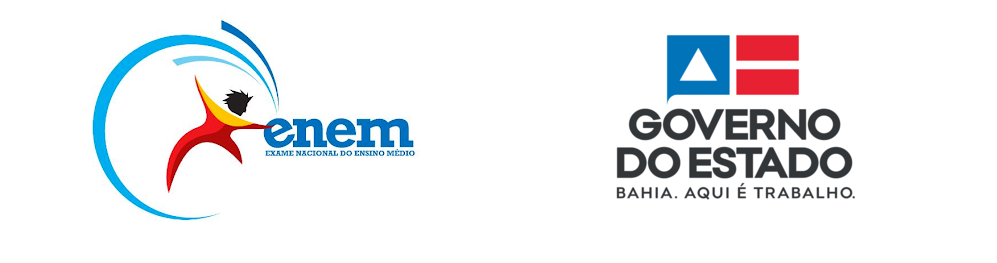

# <b><center>ANÁLISE ACERCA DO ENEM NO ESTADO DA BAHIA NOS ANOS DE 2017, 2018 E 2019</center><b>


# Baixando, extraindo, lendo e filtrando os dados

<b> Obs:</b>Execute as células desse tópico apenas se for precisar utilizar os dados para execução do restante do projeto, se for apenas observar a análise não execute. São mais de 10 GB em dados após a extração.

## Montando drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalando bibliotecas para importação dos dados

In [6]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=989d65ec8119126b5f3a6b25b81b91886ded4f6ba000e5a995b7ea36b71f0206
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [7]:
!python -m pip install "dask[complete]"

     |████████████████████████████████| 92kB 4.6MB/s 
     |████████████████████████████████| 665kB 2.2MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=076b45f04d0d7723e53ecb2d8638b7a4f3c740b687bc60334e10f4ba457eb8d2
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=388ea964b7eaad4234da55a7f376cd1948fd6690fd0134cb9c281c5ece75228c
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built locket contextvars
ERROR: distributed 2.30.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


## Baixando microdados do ENEM

In [ ]:
import wget

url = "http://download.inep.gov.br/microdados/microdados_enem2017.zip"
wget.download(url, '/content/drive/My Drive/DADOS_ENEM/enem_2017.zip')

url = "http://download.inep.gov.br/microdados/microdados_enem2018.zip"
wget.download(url, '/content/drive/My Drive/DADOS_ENEM/enem_2018.zip')

url = "http://download.inep.gov.br/microdados/microdados_enem_2019.zip"
wget.download(url, '/content/drive/My Drive/DADOS_ENEM/enem_2019.zip')

## Extraindo dados dos arquivoz Zip

In [3]:
from zipfile import ZipFile

# Para extrair
with ZipFile('/content/drive/My Drive/DADOS_ENEM/enem_2017.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/DADOS_ENEM/enem_2017')

with ZipFile('/content/drive/My Drive/DADOS_ENEM/enem_2018.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/DADOS_ENEM/enem_2018')

with ZipFile('/content/drive/My Drive/DADOS_ENEM/enem_2019.zip', 'r') as zip:
   zip.extractall('/content/drive/My Drive/DADOS_ENEM/enem_2019')

FileNotFoundError: ignored

## Lendo os dados com dask.dataframe

In [8]:
import dask.dataframe as dd

enem_2017 = dd.read_csv('drive/My Drive/DADOS_ENEM/enem_2017/Microdados Enem 2017/DADOS/MICRODADOS_ENEM_2017.csv', sep=';', encoding='latin1', assume_missing=True)
enem_2018 = dd.read_csv('drive/My Drive/DADOS_ENEM/enem_2018/DADOS/MICRODADOS_ENEM_2018.csv', sep=';', encoding='latin1', assume_missing=True)
enem_2019 = dd.read_csv('drive/My Drive/DADOS_ENEM/enem_2019/DADOS/MICRODADOS_ENEM_2019.csv', sep=';', encoding='latin1')

## Filtrando apenas os registros da Bahia

In [9]:
import pandas as pd

enem_ba_2017 = pd.DataFrame(enem_2017[enem_2017['SG_UF_RESIDENCIA'] == 'BA'].compute()).reset_index(drop=True)
enem_ba_2018 = pd.DataFrame(enem_2018[enem_2018['SG_UF_RESIDENCIA'] == 'BA'].compute()).reset_index(drop=True)
enem_ba_2019 = pd.DataFrame(enem_2019[enem_2019['SG_UF_RESIDENCIA'] == 'BA'].compute()).reset_index(drop=True)

# Tratamento dos dados prévio
### O principal objetivo é a melhoria do desempenho

In [10]:
# Excluíndo as colunas que são diferentes entre os dataframes

In [11]:
diff_17_19 = [element for element in enem_ba_2017.columns if element not in enem_ba_2019.columns]
diff_18_19 = [element for element in enem_ba_2018.columns if element not in enem_ba_2019.columns]
diff_17_18 = [element for element in enem_ba_2017.columns if element not in enem_ba_2018.columns]
diff_18_17 = [element for element in enem_ba_2018.columns if element not in enem_ba_2017.columns]
diff_19_17 = [element for element in enem_ba_2019.columns if element not in enem_ba_2017.columns]
diff_19_18 = [element for element in enem_ba_2019.columns if element not in enem_ba_2018.columns]
print('17-19:',diff_17_19,'\n18-19:',diff_18_19,'\n19-18:',diff_19_18,'\n17-18:',diff_17_18,'\n19-17:',diff_19_17,'\n18-17:',diff_18_17)

17-19: ['Q026', 'Q027'] 
18-19: ['Q026', 'Q027'] 
19-18: ['IN_TEMPO_ADICIONAL'] 
17-18: [] 
19-17: ['IN_TEMPO_ADICIONAL'] 
18-17: []


In [12]:
enem_ba_2017.drop(diff_17_19, axis=1, inplace=True)
enem_ba_2018.drop(diff_18_19, axis=1, inplace=True)
enem_ba_2019.drop(diff_19_17, axis=1, inplace=True)

### Reduzindo todos os dados relacionados a atendimento especializado em 1 única coluna

Para melhoria de desempenho iremos agora reduzir a dimensão dos meus dados, há muitas colunas que não necessitaremos daqui pra frente (códigos,  gabirito, etc), há também conjuntos de colunas que podemos reduzir a apenas uma coluna, no caso reduziremos todos os dados do tópico de atendimento especializado (melhor observável dentro do dicionário de dados) e atendimento específico, por apenas uma coluna para cada, essa coluna representará o tópico ao todo.

Excluiremos quase todas as colunas do tópico de dados dos pedidos de recursos especializados e específicos para a realização das provas, deixando apenas a coluna IN_SEM_RECURSO, a qual diz se o candidato realizou ou não algum pedido de recurso.


In [13]:
enem_ba_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493468 entries, 0 to 493467
Columns: 135 entries, NU_INSCRICAO to Q025
dtypes: float64(94), object(41)
memory usage: 508.3+ MB


In [14]:
def colunas_importantes(df):
  df_tratado = df.copy()
  #Criando coluna 'NU_NOTA_TOTAL' com a soma das notas de cada aluno
  provas = ['NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']
  df_tratado['NU_NOTA_TOTAL'] = df_tratado[provas].sum(axis=1)

  #Reduzindo todos os dados relacionados a atendimento especializado em 1 única coluna
  atendimento_especializado = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
                             'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']
  df_tratado['IN_ATENDIMENTO_ESPECIALIZADO'] = df[atendimento_especializado].sum(axis=1) != 0
  df_tratado['IN_ATENDIMENTO_ESPECIALIZADO'] = df_tratado['IN_ATENDIMENTO_ESPECIALIZADO'].apply(lambda x: 1 if x == True else 0)

  #Reduzindo todos os dados relacionados a atendimento específico em 1 única coluna (IN_IDOSO será excluída depois, pois será necessária no tratamento de outliers)
  atendimento_especifico = ['IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR']
  df_tratado['IN_ATENDIMENTO_ESPECIFICO'] = df[atendimento_especifico].sum(axis=1) != 0
  df_tratado['IN_ATENDIMENTO_ESPECIFICO'] = df_tratado['IN_ATENDIMENTO_ESPECIFICO'].apply(lambda x: 1 if x == True else 0)

  #A coluna 'IN_SEM_RECURSO', já presente no dataframe, pode representar todos os dados dos pedidos de recursos especializados e específicos
  colunas_desnecessarias = ['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC',
                  'CO_UF_ESC', 'CO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
                  'TX_GABARITO_LC', 'TX_GABARITO_MT', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
                  'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR',
                  'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
                  'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL', 
                  'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO', 'IN_NOME_SOCIAL', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 
                  'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
                  'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'TX_RESPOSTAS_CN']
  
  # Dropando as colunas desnecessárias
  df_tratado.drop(colunas_desnecessarias, axis=1, inplace=True)
  
  return df_tratado


In [15]:
enem_ba_2017 = colunas_importantes(enem_ba_2017)
enem_ba_2018 = colunas_importantes(enem_ba_2018)
enem_ba_2019 = colunas_importantes(enem_ba_2019)

In [16]:
lista_de_dataframes = [enem_ba_2017, enem_ba_2018, enem_ba_2019]

In [17]:
for i in lista_de_dataframes:
  print('Quantidade de linhas em {}:'.format(int(i['NU_ANO'].mean())), i.shape[0])

Quantidade de linhas em 2017: 493468
Quantidade de linhas em 2018: 401328
Quantidade de linhas em 2019: 398095


In [18]:
for i in lista_de_dataframes:
  print('Quantidade de colunas em {}:'.format(int(i['NU_ANO'].mean())), i.shape[1])

Quantidade de colunas em 2017: 70
Quantidade de colunas em 2018: 70
Quantidade de colunas em 2019: 70


# Análise exploratória dos dados.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_palette('vlag', color_codes=True)

## Analisando os alunos faltantes e excluíndo-os da análise

* Analisaremos aqui as principais motivações para os alunos terem faltado ao exame

<h3><b>Informação:</b> As ordens das provas por dia em ambos os anos foram...</h3>

<b>1º Dia</b>

– Linguagens, Códigos e suas Tecnologias: Língua Portuguesa; Literatura; Língua Estrangeira – Inglês ou Espanhol; Artes; Educação Física; Tecnologias da Informação e Comunicação.

– Ciências Humanas e suas Tecnologias: História; Geografia; Filosofia; Sociologia.

– Redação

<b>2º Dia</b>

– Ciências da Natureza e suas Tecnologias: Química; Física; Biologia.

– Matemática e suas tecnologias: Matemática.

### Análises

#### Relação entre as faltas no 1º e 2º dia de prova

In [107]:
# Criando variáveis para a plotagem de gráficos sobre presença
for ano in lista_de_dataframes:
  presenca_geral = []
  ano['PRESENCA_DIA_1'] = [0 if presenca == True else 1 for presenca in ((ano['TP_PRESENCA_LC'] == 0) & (ano['TP_PRESENCA_CH'] == 0))]
  ano['PRESENCA_DIA_2'] = [0 if presenca == True else 1 for presenca in ((ano['TP_PRESENCA_MT'] == 0) & (ano['TP_PRESENCA_CN'] == 0))]

  for presenca1, presenca2 in ano[['PRESENCA_DIA_1', 'PRESENCA_DIA_2']].values:
    if presenca1 == 0:
      if presenca2 == 0:
        presenca_geral.append('00')
      else:
        presenca_geral.append('01')
    else:
      if presenca2 == 0:
        presenca_geral.append('10')
      else:
        presenca_geral.append('11')

  ano['PRESENCA_GERAL'] = presenca_geral

Iremos observar os alunos que:

* Faltaram nos dois dias de prova (00);
* Foram nos dois dias de prova (11);
* Faltaram apenas o primeiro dia (01);
* Faltaram apenas o segundo dia (10).

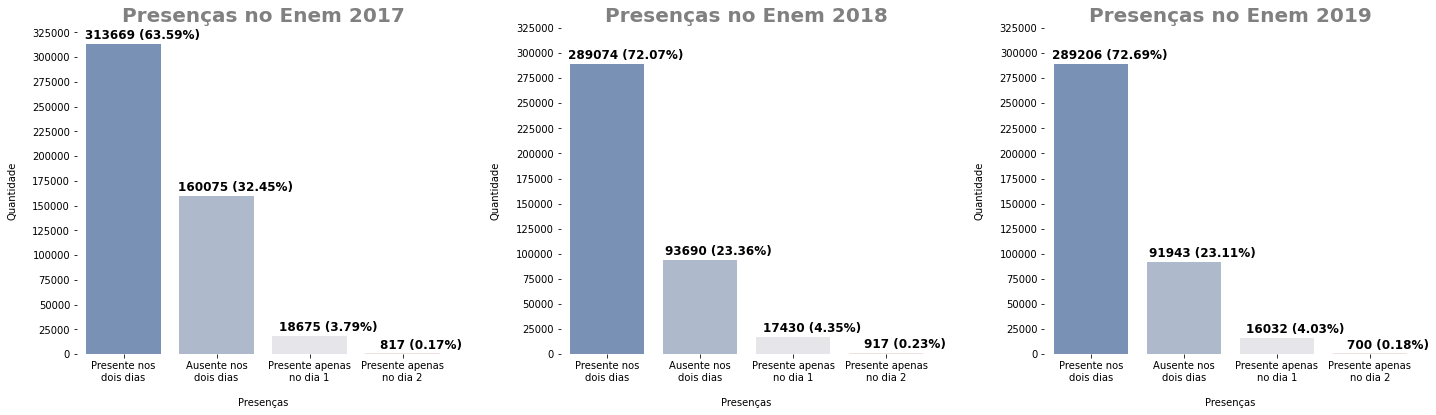

In [108]:
plt.figure(figsize=(24,6))
plt.subplots_adjust(wspace=0.3)
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano, x='PRESENCA_GERAL', order=['11','00','10','01'])
  sns.despine(bottom = True, left = True)
  plt.xticks([0,1,2,3], ['Presente nos\ndois dias', 'Ausente nos\ndois dias', 'Presente apenas\nno dia 1', 'Presente apenas\nno dia 2'])
  plt.yticks(np.arange(0,330000, 25000))
  plt.title('Presenças no Enem {}'.format(int(ano['NU_ANO'].mean())), fontsize=20,  color='grey', fontweight = 'heavy')
  plt.xlabel('Presenças', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=0.2+(p.get_x()+p.get_width()/2.), y=height + 5000, s='{} ({:.2f}%)'.format(height, 100 * height/len(ano)),
                ha="center", fontweight='heavy', fontsize=12)

Observa-se que quando os alunos faltam o primeiro dia de prova raramente eles vão no segundo dia, pois a nota total já se reduz em 3/5 pois são 3 provas.

Vamos isolá-los para observar de forma mais clara.

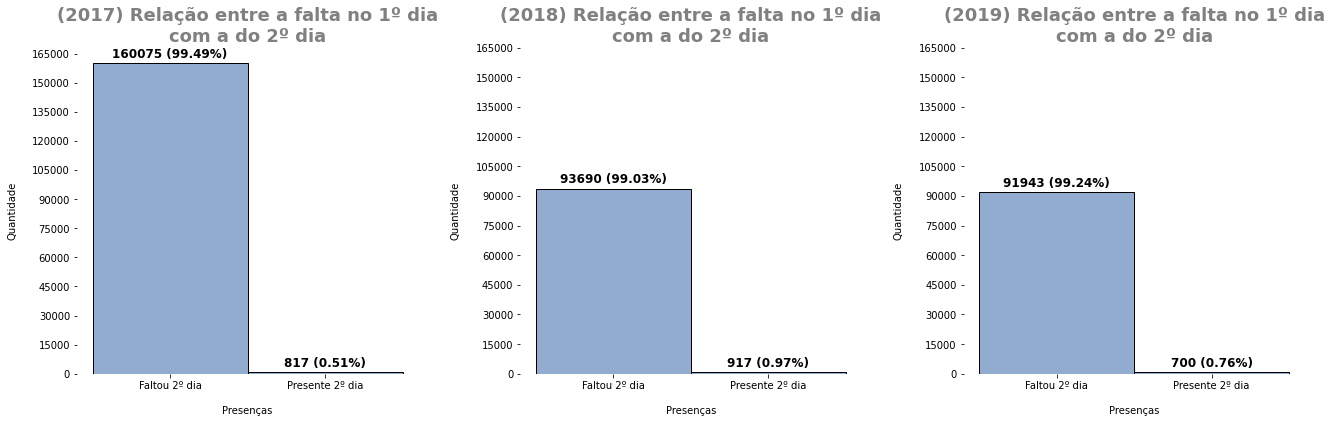

In [109]:
i=1
plt.figure(figsize=(22,6))
plt.subplots_adjust(wspace=0.3)

for ano in lista_de_dataframes:
  plt.subplot(1,3,i) 
  plot = sns.histplot(ano[ano['PRESENCA_DIA_1'] == 0], x='PRESENCA_GERAL')
  sns.despine(bottom = True, left = True)
  plt.title('({}) Relação entre a falta no 1º dia\ncom a do 2º dia'.format(int(ano['NU_ANO'].mean())), fontsize=18, color='grey', fontweight = 'heavy')
  plt.xticks([0,1], ['Faltou 2º dia', 'Presente 2º dia'])
  plt.yticks(np.arange(0,170000, 15000))
  plt.xlabel('Presenças', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
        height = p.get_height()
        plot.text(x=p.get_x()+p.get_width()/2., y=height + 2800, s='{} ({:.2f}%)'.format(height, 100 * height/len(ano[ano['PRESENCA_DIA_1'] == 0])),
                  ha="center", fontweight='heavy', fontsize=12)

Fica mais nítido ainda que ao faltarem no 1º dia de prova, grande maioria (mais do que 99%) já desiste do 2º dia.

#### Relação entre o fator do participante ter veículo (carro ou moto) em casa e as faltas

In [110]:
# Criando a variável para distinguir inscritos que têm ou não veículo

for ano in lista_de_dataframes:
  tem_veiculo = []
  for carro, moto in ano[['Q010','Q011']].values:
    if ((carro == 'A') & (moto == 'A')):
      tem_veiculo.append(0)
    else:
      tem_veiculo.append(1)
    
  ano['TEM_VEICULO'] = tem_veiculo

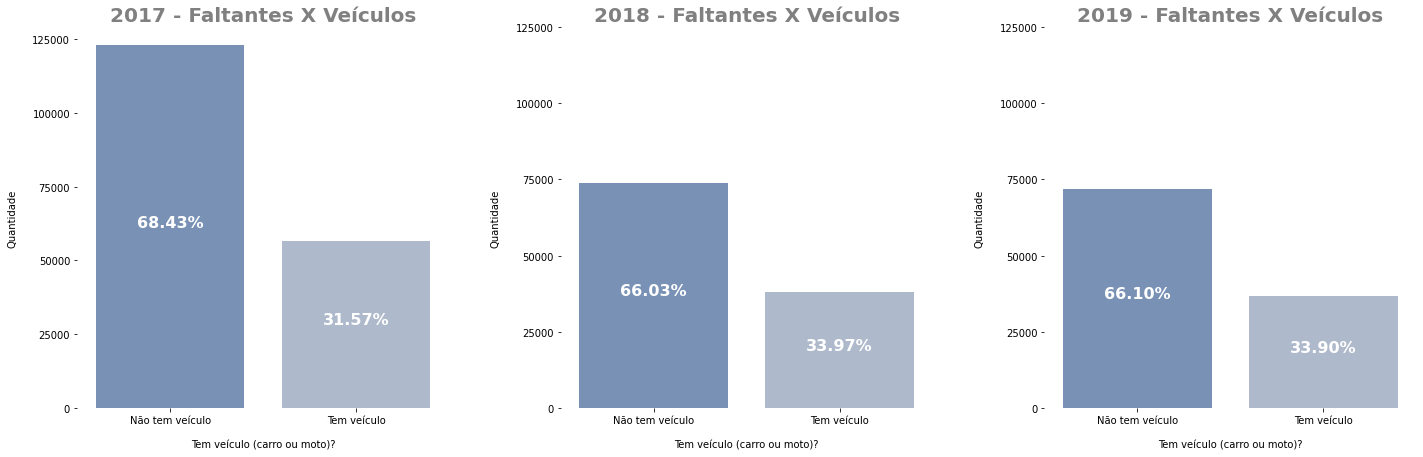

In [111]:
plt.figure(figsize=(24,7))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano[ano['PRESENCA_GERAL'] != '11'], x='TEM_VEICULO')
  sns.despine(bottom = True, left = True)
  plt.xticks([0,1], ['Não tem veículo', 'Tem veículo'])
  plt.yticks(np.arange(0,150000, 25000))
  plt.title('{} - Faltantes X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Tem veículo (carro ou moto)?', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_GERAL'] != '11'])),
                ha="center", color='white', fontweight='heavy', fontsize=16)

Maior parcela das pessoas que faltaram em quaisquer dos dias ou ambos, não tinham veículo (carro ou moto) nas suas casas.

Será que isso ocorreu tanto no 1º quanto no 2º dias do Enem ou a questão discutida acima sobre a relação entre as faltas no 1º dia com as do 2º vai alterar um pouco essa contagem?

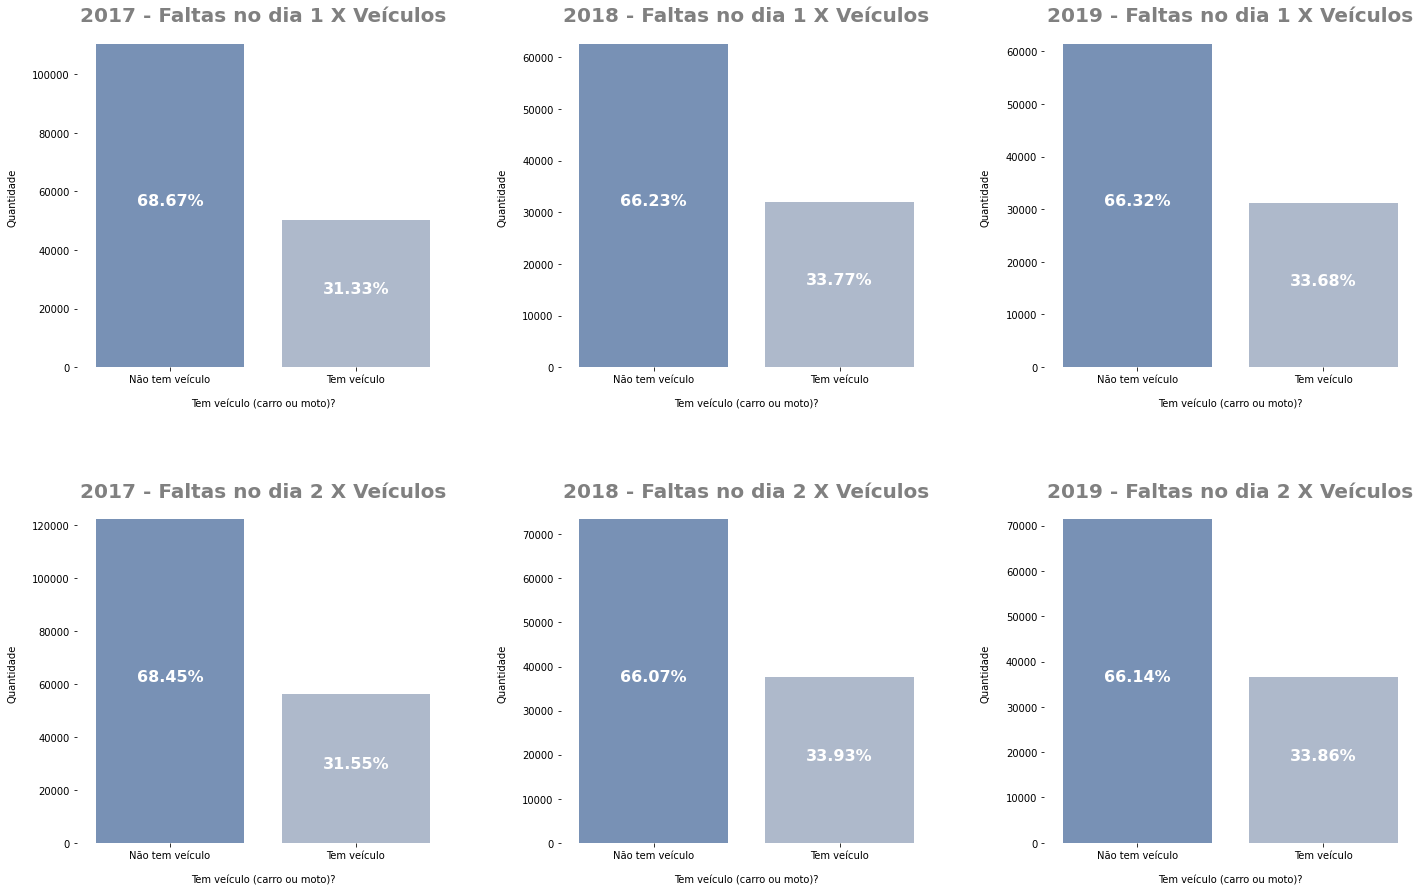

In [112]:
plt.figure(figsize=(24,15))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
i=1

for ano in lista_de_dataframes:
  plt.subplot(2,3,i)
  plot1 = sns.countplot(data=ano[ano['PRESENCA_DIA_1'] == 0], x='TEM_VEICULO', order=[0,1])
  plt.xticks([0,1], ['Não tem veículo', 'Tem veículo'])
  plt.title('{} - Faltas no dia 1 X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Tem veículo (carro ou moto)?', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  for p in plot1.patches:
      height = p.get_height()
      plot1.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_DIA_1'] == 0])),
                 ha="center", color='white', fontweight='heavy', fontsize=16)
  
  plt.subplot(2,3,i+3)
  plot2 = sns.countplot(data=ano[ano['PRESENCA_DIA_2'] == 0], x='TEM_VEICULO', order=[0,1])
  plt.xticks([0,1], ['Não tem veículo', 'Tem veículo'])
  plt.title('{} - Faltas no dia 2 X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Tem veículo (carro ou moto)?', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  for p in plot2.patches:
      height = p.get_height()
      plot2.text(x=p.get_x()+p.get_width()/2., y=height-height/2, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_DIA_2'] == 0])),
                 ha="center", color='white', fontweight='heavy', fontsize=16)

  sns.despine(bottom = True, left = True)
  i+=1

O fator dos inscritos terem ou não veículos implica bastante nas faltas, tanto no dia 1 quanto no dia 2 do Enem na Bahia.

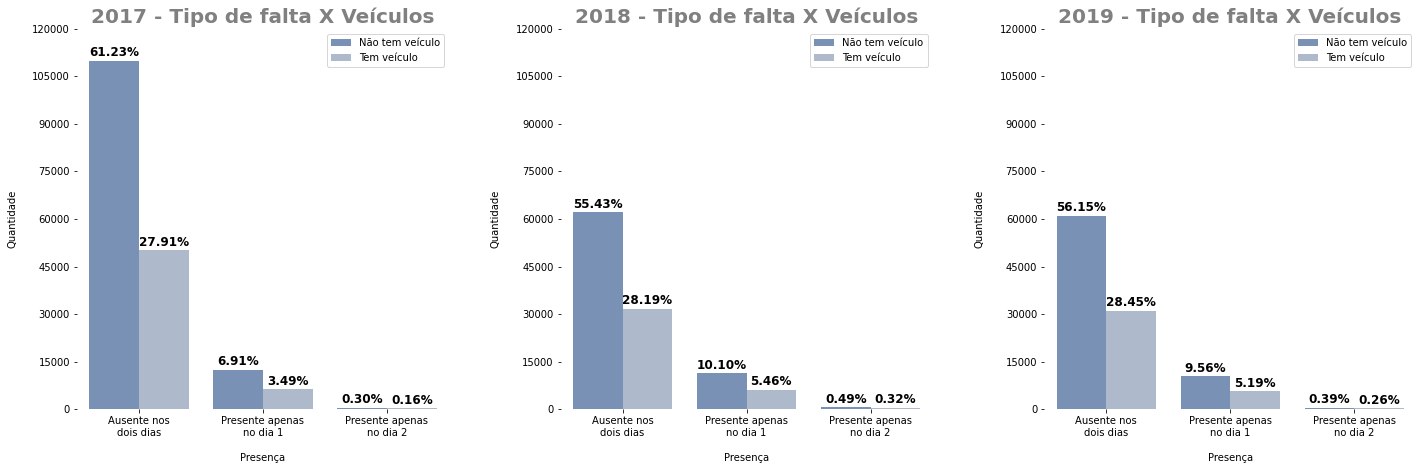

In [113]:
plt.figure(figsize=(24,7))
plt.subplots_adjust(wspace=0.3)
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plot = sns.countplot(data=ano[ano['PRESENCA_GERAL'] != '11'], x='PRESENCA_GERAL', hue='TEM_VEICULO', order=['00','10','01'])
  plot.legend(labels=['Não tem veículo', 'Tem veículo'])
  plt.xticks([0,1,2], ['Ausente nos\ndois dias', 'Presente apenas\nno dia 1', 'Presente apenas\nno dia 2'])
  plt.yticks(np.arange(0,130000, 15000))
  plt.title('{} - Tipo de falta X Veículos'.format(int(ano['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Presença', labelpad = 15)
  plt.ylabel('Quantidade', labelpad = 15)
  i+=1
  for p in plot.patches:
      height = p.get_height()
      plot.text(x=p.get_x()+p.get_width()/2., y=height + 1500, s='{:.2f}%'.format(100 * height/len(ano[ano['PRESENCA_GERAL'] != '11'])),
                ha="center", fontweight='heavy', fontsize=12)
      
  sns.despine(bottom = True, left = True)

Observando todos esses gráficos nós podemos perceber que na Bahia a probabilidade de um inscrito que não tem nenhum veículo automotivo em casa faltar no dia da prova é muito maior do que pra aqueles que possuem.

Sejam as faltas apenas no 1º dia, apenas no 2º ou em ambos os dias, a maioria delas sempre ocorre com pessoas que não têm nem um carro e nem uma moto em suas casas.

Em todos os anos mais de 55% dos inscritos faltaram nos dois dias e também não possuíam veículos automotivos em casa.

### Excluindo os inscritos que não foram fazer a prova em nenhum dos dias

Percebemos aqui que há variáveis com muitos valores nulos, teremos que tratar todas elas e primeiramente iremos excluir os valores nulos realcionados aos alunos que faltaram em todas as provas.

In [114]:
for i in lista_de_dataframes:
  print('Tamanho atual do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho atual do DF de 2017: (493236, 74)
Tamanho atual do DF de 2018: (401111, 74)
Tamanho atual do DF de 2019: (397881, 74)


In [115]:
faltas = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC']

enem_ba_2017.drop(enem_ba_2017[enem_ba_2017['PRESENCA_GERAL'] == '00'].index, inplace=True)
enem_ba_2018.drop(enem_ba_2018[enem_ba_2018[faltas].sum(axis=1) == 0].index, inplace=True)
enem_ba_2019.drop(enem_ba_2019[enem_ba_2019[faltas].sum(axis=1) == 0].index, inplace=True)

In [116]:
for i in lista_de_dataframes:
  print('Novo tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Novo tamanho do DF de 2017: (333161, 74)
Novo tamanho do DF de 2018: (307418, 74)
Novo tamanho do DF de 2019: (305938, 74)


## Analisando as medidas de tendência central e dispersão

In [117]:
enem_ba_2017.head()

,NU_ANO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,NO_MUNICIPIO_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_SEM_RECURSO,NO_MUNICIPIO_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL,IN_ATENDIMENTO_ESPECIALIZADO,IN_ATENDIMENTO_ESPECIFICO,PRESENCA_DIA_1,PRESENCA_DIA_2,PRESENCA_GERAL,TEM_VEICULO
0,2017.0,Salvador,BA,26.0,F,0.0,0.0,1.0,Salvador,BA,1.0,7.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Salvador,BA,1.0,1.0,1.0,1.0,392.0,396.0,400.0,404.0,613.2,616.7,623.1,656.5,1.0,140.0,120.0,120.0,120.0,60.0,560.0,G,F,D,B,6.0,J,A,D,D,B,B,B,B,B,B,B,A,A,D,A,B,E,B,E,B,3069.5,0,0,1,1,11,1
2,2017.0,Catu,BA,30.0,F,0.0,2.0,1.0,Catu,BA,1.0,11.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Catu,BA,1.0,1.0,1.0,1.0,394.0,397.0,402.0,405.0,521.7,590.8,561.9,622.8,1.0,140.0,120.0,140.0,160.0,120.0,680.0,B,B,C,B,4.0,B,A,B,D,A,A,B,B,B,A,B,A,A,B,B,A,D,A,A,A,2977.2,0,0,1,1,11,0
3,2017.0,Jequié,BA,25.0,F,0.0,3.0,1.0,Jequié,BA,1.0,8.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Jequié,BA,1.0,1.0,1.0,1.0,392.0,397.0,402.0,404.0,534.9,634.1,597.9,472.9,1.0,140.0,120.0,140.0,140.0,140.0,680.0,C,E,B,B,4.0,C,A,B,C,A,B,B,A,A,A,B,A,B,B,B,A,C,A,B,B,2919.8,0,0,1,1,11,1
4,2017.0,Salvador,BA,22.0,F,0.0,2.0,1.0,Fortaleza,CE,1.0,5.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Salvador,BA,1.0,1.0,1.0,1.0,394.0,395.0,399.0,405.0,653.0,677.7,643.9,696.1,1.0,140.0,140.0,160.0,140.0,80.0,660.0,C,C,E,F,3.0,M,C,E,E,D,A,B,A,B,A,B,A,B,D,A,B,D,B,C,B,3330.7,0,0,1,1,11,1
5,2017.0,Lauro de Freitas,BA,20.0,M,0.0,2.0,1.0,Salvador,BA,1.0,2.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Lauro de Freitas,BA,1.0,1.0,1.0,1.0,392.0,395.0,399.0,404.0,545.9,574.0,585.2,528.1,1.0,100.0,120.0,140.0,120.0,140.0,620.0,E,E,B,C,6.0,E,A,B,C,A,A,B,A,A,A,B,A,A,B,A,A,D,B,B,B,2853.2,0,0,1,1,11,0


In [118]:
variaveis_categoricas = ['SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'SG_UF_NASCIMENTO',
                         'NO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
                         'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_SEM_RECURSO', 'NO_MUNICIPIO_PROVA',
                         'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO',
                         'Q001',	'Q002',	'Q003',	'Q004',	'Q005',	'Q006',	'Q007',	'Q008',	'Q009',	'Q010',	'Q011',	'Q012',	'Q013',	'Q014',	'Q015',
                         'Q016',	'Q017',	'Q018',	'Q019',	'Q020',	'Q021',	'Q022',	'Q023',	'Q024',	'Q025', 'IN_ATENDIMENTO_ESPECIALIZADO',	'IN_ATENDIMENTO_ESPECIFICO']

variaveis_numericas = ['NU_ANO', 'NU_IDADE', 'TP_ANO_CONCLUIU', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
                       'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
                       'NU_NOTA_COMP4']

In [119]:
enem_ba_2017[variaveis_numericas].describe()

,NU_ANO,NU_IDADE,TP_ANO_CONCLUIU,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_TOTAL,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP4
count,333161.0,333157.000000,333161.000000,314433.000000,332223.000000,332223.000000,314433.000000,332223.000000,333161.000000,332223.000000,332223.000000,332223.000000,332223.000000,332223.000000
mean,2017.0,22.574990,3.150777,501.556049,507.599221,498.212624,497.354526,516.489045,2460.773673,114.175178,111.060402,105.186516,107.089937,107.089937
std,0.0,7.525493,3.817224,69.441449,82.065320,66.760172,96.417113,190.550746,475.658280,40.081119,41.119974,41.517095,41.172914,41.172914
min,2017.0,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.0,18.000000,0.000000,447.300000,445.500000,455.600000,421.500000,440.000000,2233.200000,100.000000,100.000000,80.000000,80.000000,80.000000
50%,2017.0,20.000000,1.000000,496.000000,506.400000,502.000000,479.500000,540.000000,2480.200000,120.000000,120.000000,120.000000,120.000000,120.000000
75%,2017.0,24.000000,5.000000,549.700000,569.000000,544.700000,556.100000,620.000000,2746.700000,140.000000,120.000000,120.000000,120.000000,120.000000
max,2017.0,79.000000,11.000000,848.300000,845.200000,779.300000,993.900000,1000.000000,4143.500000,200.000000,200.000000,200.000000,200.000000,200.000000


In [120]:
for i in variaveis_categoricas:
  print(enem_ba_2017[i].value_counts())

BA    333161
Name: SG_UF_RESIDENCIA, dtype: int64
F    205994
M    127167
Name: TP_SEXO, dtype: int64
0.0    291134
1.0     26765
2.0      2985
3.0       447
Name: TP_ESTADO_CIVIL, dtype: int64
3.0    172789
2.0     92776
1.0     49741
4.0      8206
0.0      7525
5.0      2124
Name: TP_COR_RACA, dtype: int64
1.0    320779
2.0     11524
4.0       564
3.0       195
0.0        99
Name: TP_NACIONALIDADE, dtype: int64
BA    293512
SP     11400
PE      2768
MG      2397
SE      2271
DF      1264
RJ      1204
ES       777
CE       716
GO       685
AL       649
PI       438
PA       391
PB       389
PR       342
MA       288
RS       250
RN       223
TO       169
MT       159
RO       121
AM       104
SC        99
MS        84
AC        34
RR        24
AP        21
Name: SG_UF_NASCIMENTO, dtype: int64
Salvador                75245
Feira de Santana        18131
Vitória da Conquista    11624
Juazeiro                 8084
Itabuna                  7481
                        ...  
Nova Redenção  

## Analisando as idades dos participantes do Enem na Bahia

In [121]:
def analise_idade(df):
  plt.subplots_adjust(wspace=0.3)
  sns.boxplot(data=df, x='NU_IDADE')
  plt.xticks(np.arange(0, 105, step=5))
  plt.xlim(0,100)
  plt.title('{}'.format(int(df['NU_ANO'].mode()[0])), fontsize=20, color='grey', fontweight='heavy')
  plt.text(x=0.9, y=0.9, s='Média: {0:.2f}\nMediana: {1:.2f}\nDesvio padrão: {2:.2f}'
  .format(df['NU_IDADE'].mean(), df['NU_IDADE'].median(), df['NU_IDADE'].std()), fontsize=14)
  plt.xlabel('Idade', labelpad = 15)
  sns.despine(bottom = True, left = True)

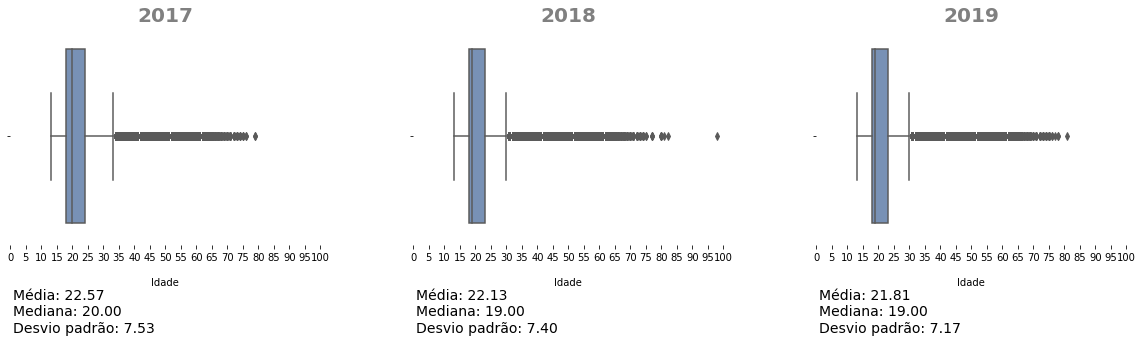

In [122]:
plt.figure(figsize=(20,4))
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  analise_idade(ano)
  i+=1

Percebemos aqui que a média de idade de concorrentes do Enem na Bahia reduziu a cada ano, mas se observarmos o boxplot de 2019 veremos alguns outliers, o que faz com que a média seja puxada pra baixo ou pra cima, o que praticamente não interfere na mediana.

Então, iremos tratar esses dados de idade.

Não existe uma idade mínima para fazer o Enem. Porém, se você estiver no segundo ano do ensino médio ou em alguma série anterior do ensino básico no ano de realização do Exame, terá que fazê-lo como treineiro e não poderá usar a sua nota para se candidatar a uma vaga na Universidade, portanto, iremos excluir todos os registros menores que 15 anos (normalmente alunos do 2º ano tem mais que 15 anos) e que ao mesmo NÃO são treineiros.

In [123]:
for i in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho do DF de 2017: (333161, 74)
Tamanho do DF de 2018: (307418, 74)
Tamanho do DF de 2019: (305938, 74)


In [124]:
for ano in lista_de_dataframes:
  ano.drop(ano[(ano['NU_IDADE'] < 15) & (ano['IN_TREINEIRO'] == 0)].index, inplace=True)

In [125]:
for i in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho do DF de 2017: (333161, 74)
Tamanho do DF de 2018: (307418, 74)
Tamanho do DF de 2019: (305938, 74)


Outra anomalia que podemos encontrar nos nossos dados é que há alguns alunos com menos de 13 anos que já estão no ensino médio, iremos excluí-los também.

In [126]:
# (TP_ST_CONCLUSAO = 3) = Estou cursando e concluirei o Ensino Médio após 2019
# (TP_ST_CONCLUSAO = 2) = Estou cursando e concluirei o Ensino Médio em 2019
# (TP_ST_CONCLUSAO = 1) = Já concluí o Ensino Médio

enem_ba_2019[(enem_ba_2019['NU_IDADE'] < 13) & (enem_ba_2019['TP_ST_CONCLUSAO'] < 4)][['NU_IDADE', 'TP_ST_CONCLUSAO', 'IN_TREINEIRO']]

,NU_IDADE,TP_ST_CONCLUSAO,IN_TREINEIRO


In [127]:
for ano in lista_de_dataframes:
  ano.drop(ano[(ano['NU_IDADE'] < 13) & (ano['TP_ST_CONCLUSAO'] < 4)].index, inplace=True)

In [128]:
for i in lista_de_dataframes:
  print('Tamanho do DF de {}: {}'.format(int(i['NU_ANO'].mean()), i.shape))

Tamanho do DF de 2017: (333161, 74)
Tamanho do DF de 2018: (307418, 74)
Tamanho do DF de 2019: (305938, 74)


Além dos outliers inferiores, que já foram tratados, nós ainda temos outliers superiores, mas nesse caso não iremos tratá-los. Dentro do próprio dicionário dos dados é dito que a coluna 'IN_IDOSO' é declarada no momento da inscrição pelo próprio candidato, dessa forma não temos como observar se a idade mínima pra uma pessoa ser considerada idosa (60 até 2020, segundo o projeto de lei 5383/19) pode coincidindo com a informação da coluna 'IN_IDOSO' nos retornando um valor negando essa condição fazer com que cheguemos à conclusão de que uma pessoa digitou a idade incorretamente, pois se  coluna 'IN_IDOSO' retornar 0, não significa que a pessoa não é idosa e sim que ela não solicitou recursos para atendimento de pessoas idosas, dessa forma, a única coluna que poderíamos utilizar para tratar esse outlier superior se torna inválida para essa análise.

Vamos plotar novamente os boxplots para ver como ficou a nossa distribuição e métricas

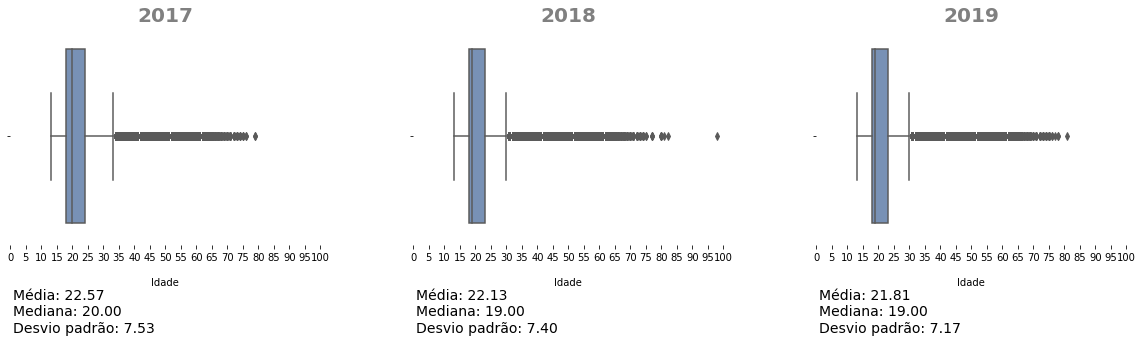

In [129]:
plt.figure(figsize=(20,4))
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  analise_idade(ano)
  i+=1

In [130]:
enem_ba_2017[enem_ba_2017['NU_IDADE'] <= 13][['NU_IDADE', 'IN_TREINEIRO', 'TP_ST_CONCLUSAO']].value_counts()

NU_IDADE  IN_TREINEIRO  TP_ST_CONCLUSAO
13.0      1.0           3.0                11
dtype: int64

In [131]:
enem_ba_2017[enem_ba_2017['NU_IDADE'] <= 14][['NU_IDADE', 'IN_TREINEIRO', 'TP_ST_CONCLUSAO']].value_counts()

NU_IDADE  IN_TREINEIRO  TP_ST_CONCLUSAO
14.0      1.0           3.0                412
13.0      1.0           3.0                 11
dtype: int64

Vejamos que os outliers inferiores desapareceram, ainda temos alunos de 13 anos, mas são todos treineiros e ainda não chegaram no ensino médio.

Podemos perceber também que todos os alunos menores ou iguais a 14 anos estão setados como treineiros (estão no segundo ano do ensino médio ou menos).

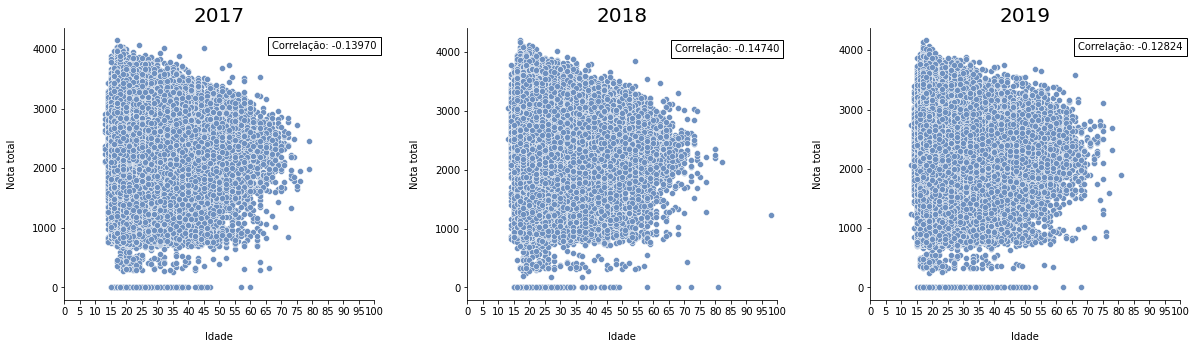

In [132]:
i=1
plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  plt.text(x=67, y=4000, s='Correlação: {:.5f}'.format(ano.corr().loc['NU_NOTA_TOTAL','NU_IDADE']), fontsize=10, bbox=dict(facecolor='white'))
  sns.scatterplot(data=ano, x='NU_IDADE', y='NU_NOTA_TOTAL')
  plt.xticks(np.arange(0, 105, step=5))
  plt.xlim(0,100)
  plt.title('{}'.format(int(ano['NU_ANO'].mean())), fontsize=20)
  plt.xlabel('Idade', labelpad = 15)
  plt.ylabel('Nota total', labelpad = 15)
  sns.despine(top = True, right = True)
  i+=1

Podemos observar que a correlação entre essas duas variáveis é ínfima, a idade do participante no Enem na Bahia é pouco ou nada relevante para a sua nota total.

## Analisando as notas e suas distribuições

In [165]:
notas = ['NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_TOTAL']

In [186]:
# Plota o histograma da nota passada por parâmetro
def hist_nota(df, coluna):
  plt.subplots_adjust(wspace=0.3, hspace=0.5)
  if df[coluna].nunique() > 100:
    sns.histplot(data=df, x=coluna, kde=True, stat='count')
    if (df[coluna].max() > 1000):
      plt.xticks(np.arange(-500, 5500, step=500))
      plt.xlim(-10,5000)
    else:
      plt.xticks(np.arange(-100, 1100, step=100))
      plt.xlim(-10,1000)

    plt.yticks(np.arange(0, 7500, step=500))
    plt.ylim(0,7000)
    plt.axvline(x=df[coluna].mean(), label='Média: {0:.2f}'.format(df[coluna].mean()), color='r', alpha=1)
    plt.axvline(x=df[coluna].median(), label='Mediana: {0:.2f}'.format(df[coluna].median()), color='g', alpha=1)
    plt.title('Histograma de {} em {}'.format(coluna, int(df['NU_ANO'].mode()[0])), fontsize=14, pad=10, color='grey', fontweight='heavy')
    plt.legend()
  else:
    sns.histplot(data=df, x=coluna, kde=True, stat='count', bins=df[coluna].nunique())
    plt.xticks(np.arange(-100, 1100, step=100))
    plt.xlim(-10,1000)
    plt.yticks(np.arange(0, 30001, step=5000))
    plt.ylim(0,30000)
    plt.axvline(x=df[coluna].mean(), label='Média: {0:.2f}'.format(df[coluna].mean()), color='r', alpha=1)
    plt.axvline(x=df[coluna].median(), label='Mediana: {0:.2f}'.format(df[coluna].median()), color='g', alpha=1)
    plt.title('Histograma de {} em {}'.format(coluna, int(df['NU_ANO'].mode()[0])), fontsize=14, pad=10, color='grey', fontweight='heavy')
    plt.legend()

# Plota o boxplot da nota passada por parâmetro
def box_nota(df, coluna):
  sns.boxplot(data=df, y=coluna)
  plt.title('Boxplot de {} em {}'.format(coluna, int(df['NU_ANO'].mode()[0])), fontsize=14, pad=10, color='grey', fontweight='heavy')
  plt.text(x=0.1, y=-100, s='Desvio padrão: {0:.2f}'.format(df[coluna].std()), fontsize=10)
  if (df[coluna].max() > 1000):
    plt.yticks(np.arange(-500, 5500, step=500))
    plt.ylim(-200,5200)
  else:
    plt.yticks(np.arange(-100, 1100, step=100))
    plt.ylim(-50,1050)
    

# Faz o plot total
def grid_nota(nota):
  plt.figure(figsize=(20,12))
  i=1

  for ano in lista_de_dataframes:
    plt.subplot(2,3,i)
    hist_nota(ano, nota)

    plt.subplot(2,3,i+3)
    box_nota(ano, nota)
    plt.ylabel('Quantidade', labelpad = 15)

    sns.despine(bottom = True, left = True)
    i+=1

### Nota total (soma de todas as notas de cada participante)

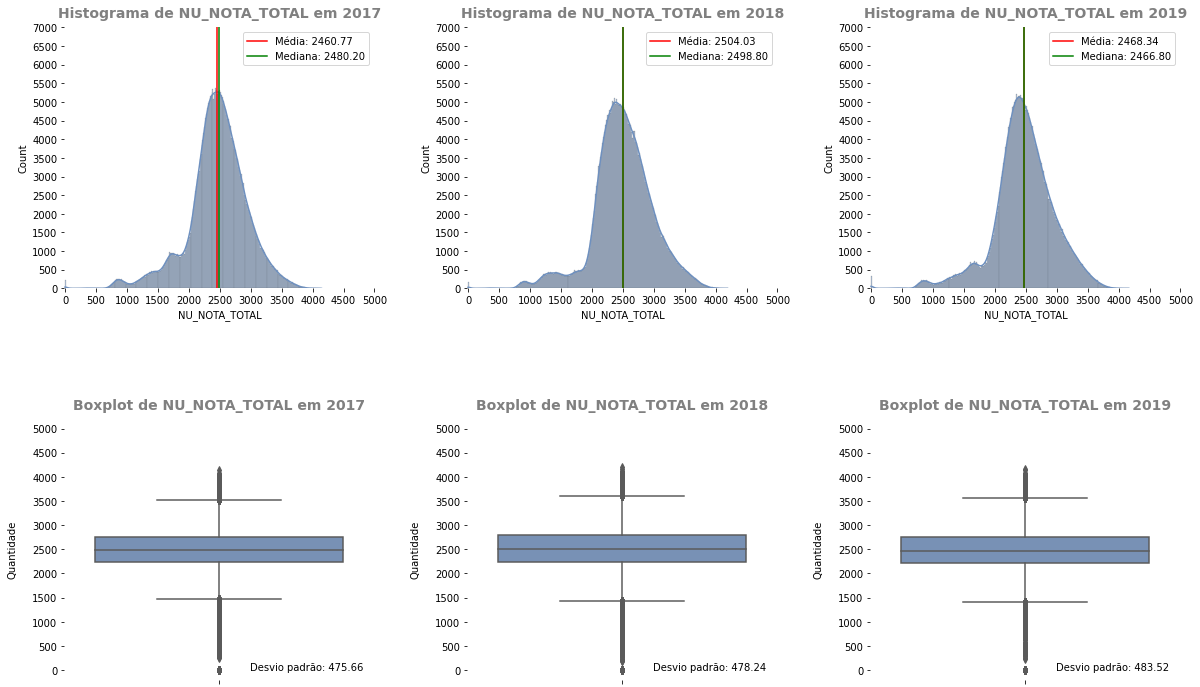

In [185]:
grid_nota('NU_NOTA_TOTAL')

Temos gráficos muito semelhantes, as médias e medianas da nota total sofreram poucas alterações durante os 3 anos, se observarmos o boxplot juntamente com o desvio padrão de cada ano, conclui-se que a distribuição também é muito semelhante.

### Notas de Matemática

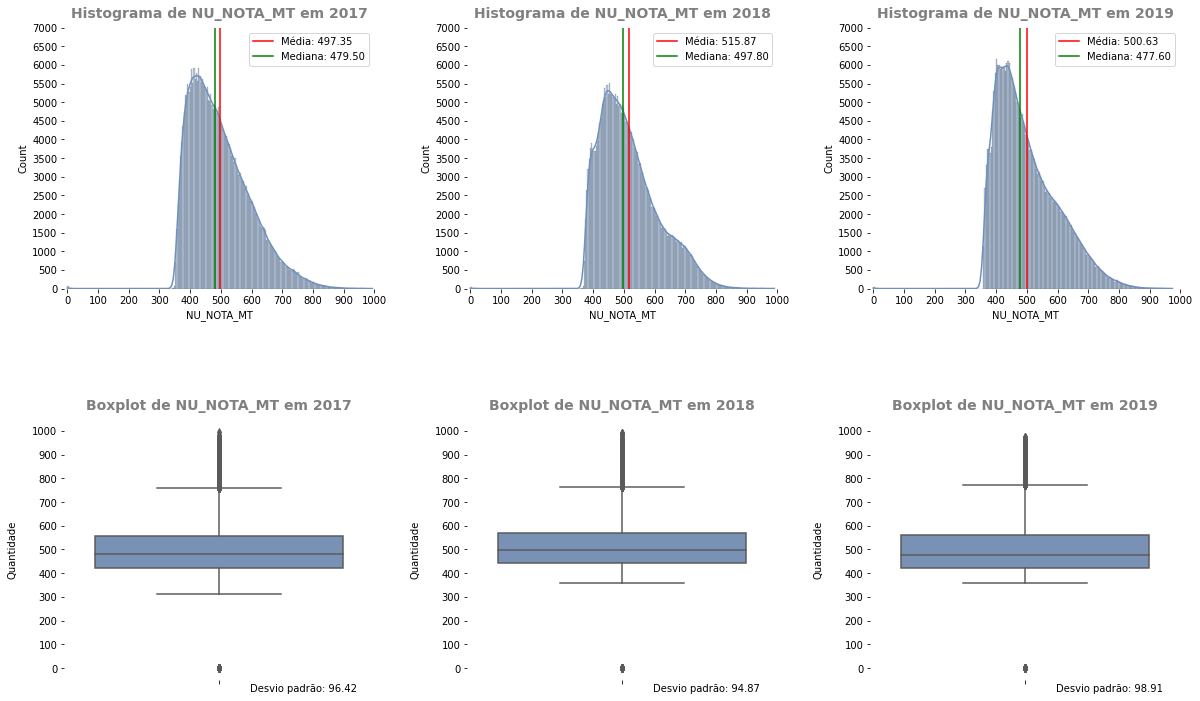

In [179]:
grid_nota('NU_NOTA_MT')

As notas de matemática também se distribuem de forma muito semelhante durante os 3 anos, mas olhando os histogramas podemos ver que há um aumento de quantidade de notas entre 600 e 750 no ano de 2018, o que implica nesse ano ter uma média e mediana maior que os outros.

### Notas de Ciências da Natureza

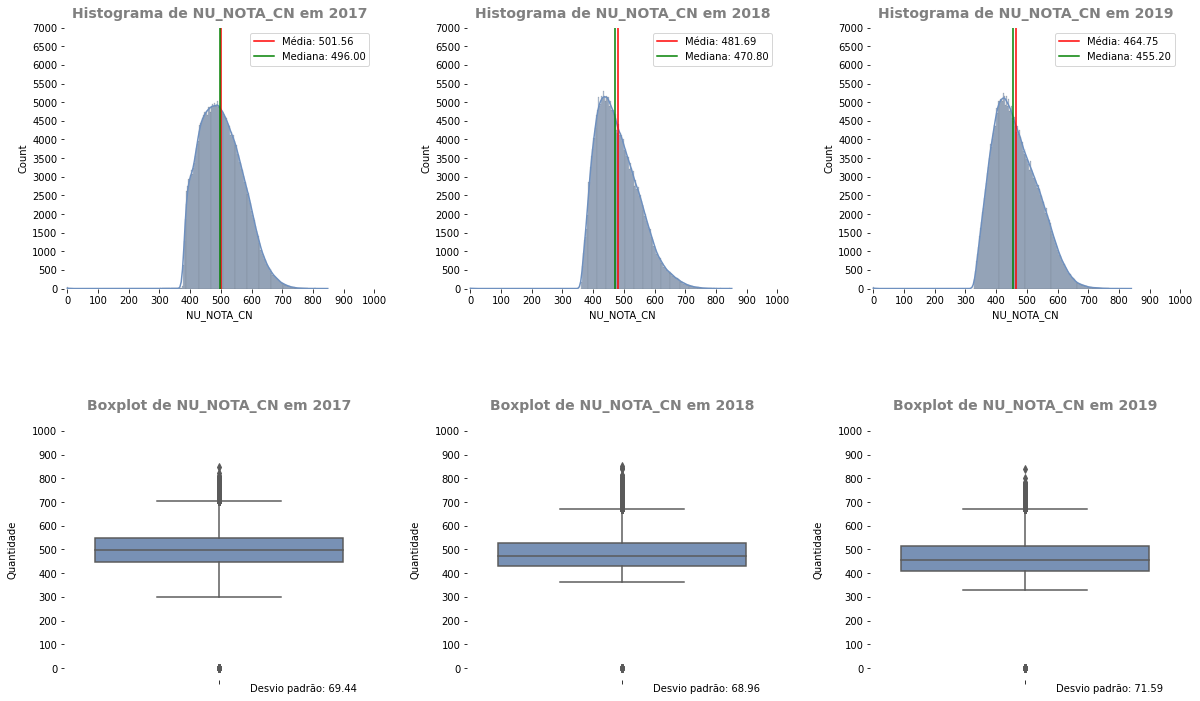

In [180]:
grid_nota('NU_NOTA_CN')

Em Ciências da Natureza, houve uma redução tanto na média quanto na mediana do ano 2017 para os dois seguintes, chegando a haver uma diferença de quase 40 em ambos de 2017 para 2019.

### Notas de Ciências Humanas

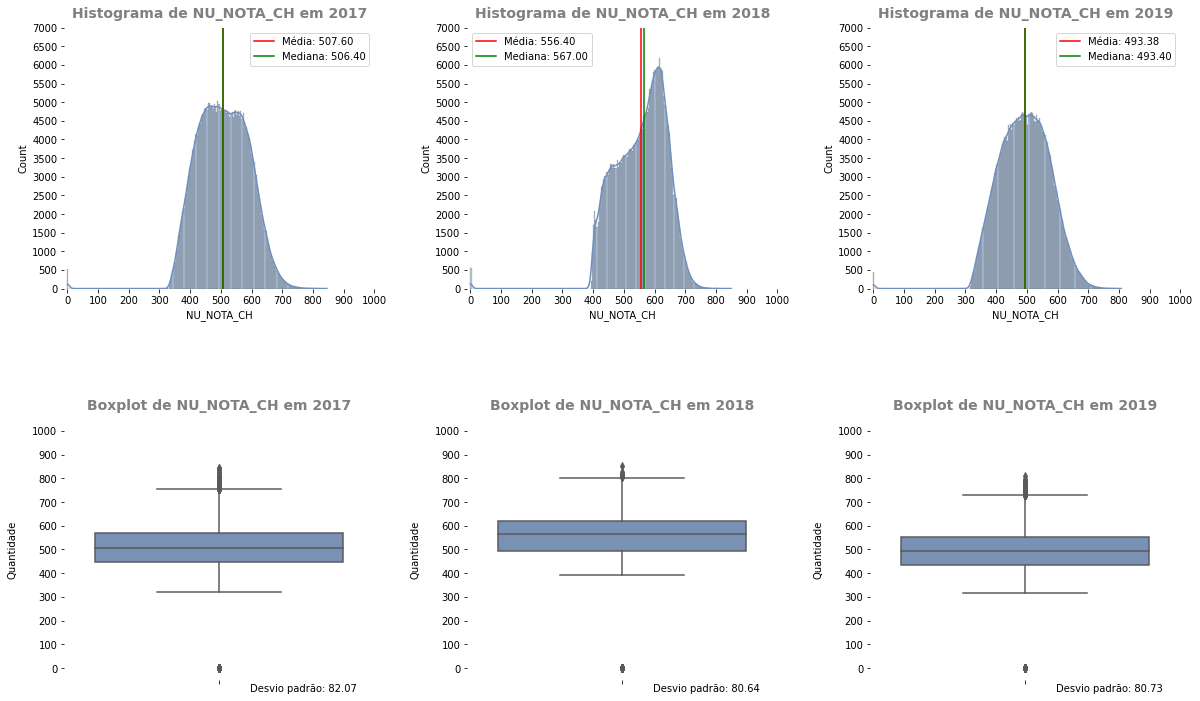

In [181]:
grid_nota('NU_NOTA_CH')

Em Ciências Humanas podemos perceber que em 2018 os dados estão concentrados nas notas maiores, de acordo com o boxplot aproximadamente 75% dos dados de 2018 sobre as notas de ciências humanas são maiores que aproximadamente 500 pontos e cerca de 50% dos dados estão acima de aproximadamente 570 pontos, enquanto que em 2017 e 2018 50% dos dados são inferiores a aproximadamente 520 pontos.

### Notas de Linguagens e Códigos

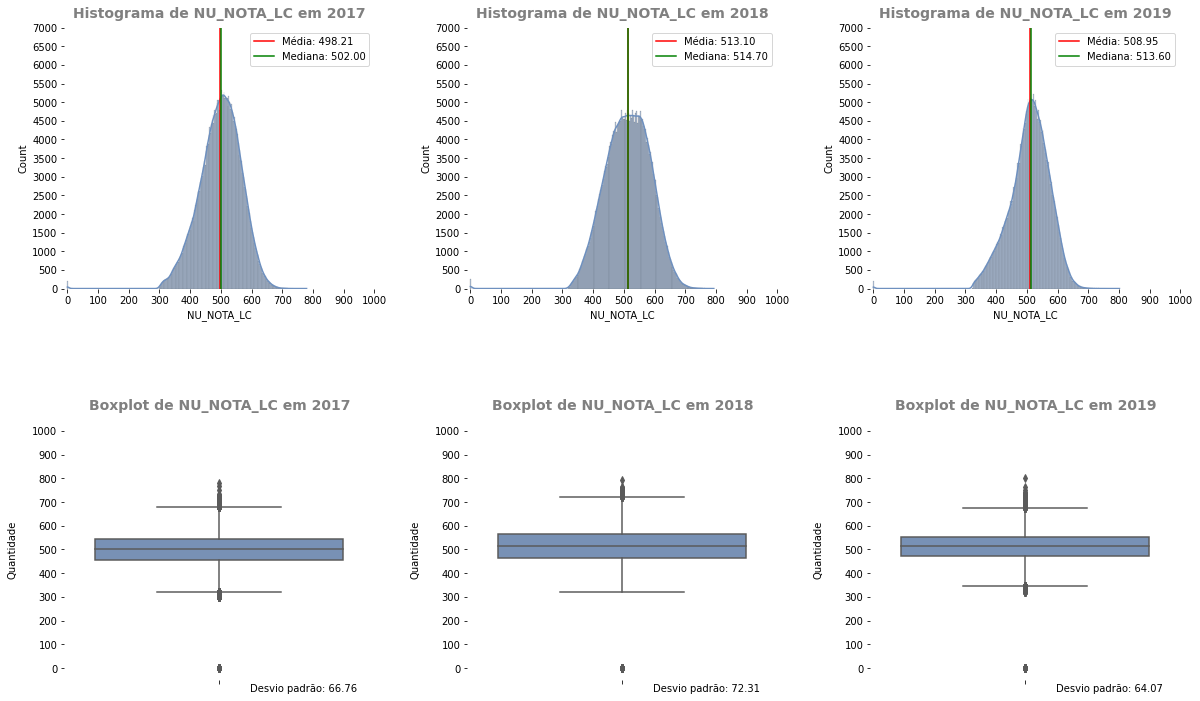

In [182]:
grid_nota('NU_NOTA_LC')

Em Linguagens e Códigos temos que em 2018 as notas foram distribuídas de forma mais espalhadas, mas mesmo assim concentraram-se um pouco mais acima do que nos outros dois anos (os quais tiveram pouquíssimas diferenças).

### Notas de Redação

Perceba que em redação as notas deixam de ser uma variável contínua e passa a ser uma variável discreta, composta por apenas 50 valores únicos.

In [172]:
enem_ba_2017['NU_NOTA_REDACAO'].nunique()

50

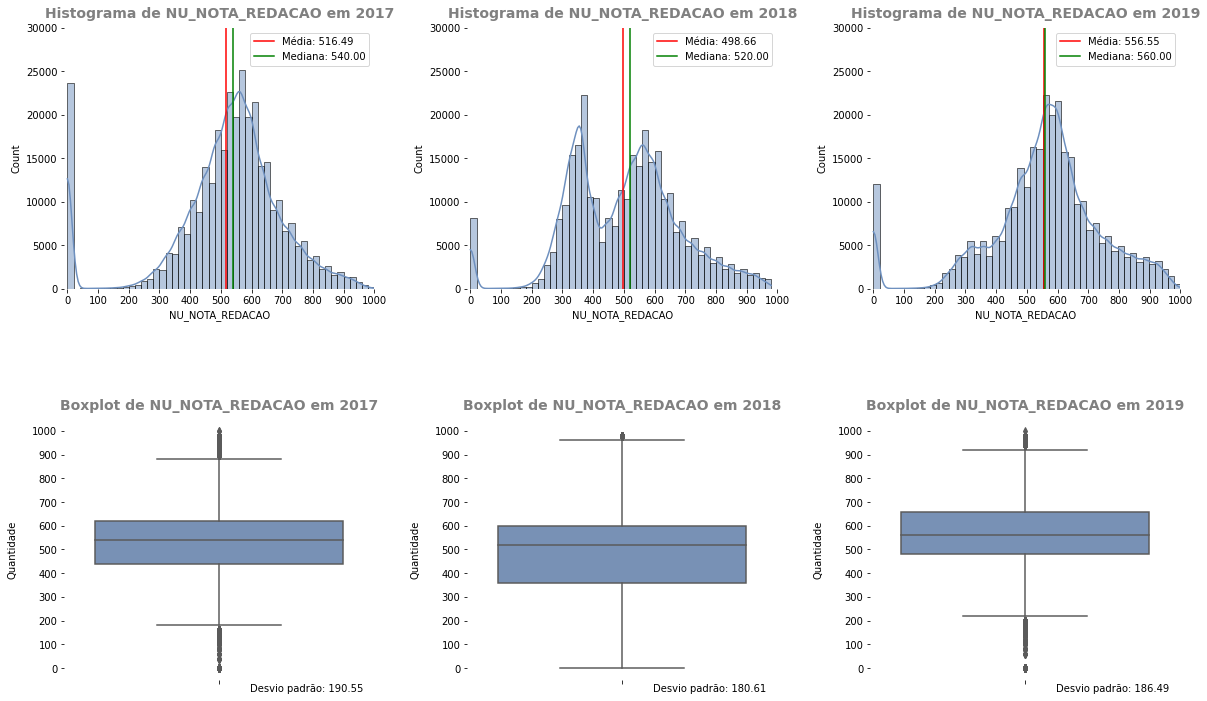

In [187]:
grid_nota('NU_NOTA_REDACAO')

É notável que em redação as notas distribuem-se mais (olhando o boxplor e o desvio padrão) e preenchem uma quantidade maior de notas do que as analisadas anteriormente.

O ano em que tivemos maiores notas de redação dentre os três foi em 2019 onde podemos observar que cerca de 75% das notas estão acima de 470 pontos e cerca de 50% das notas estão acima de 560 pontos.

### Qual prova tem mais impacto na nossa nota total?

In [206]:
def heat_corr(df):
  plt.subplots_adjust(wspace=0.4)
  sns.heatmap(data=df[notas].corr(), center=0, annot=True, cmap='vlag')
  plt.yticks(np.arange(6), ['C.Humanas', 'Matemática', 'C.Natureza', 'Linguagens', 'Redação', 'Total'])
  plt.xticks(np.arange(6), ['C.Humanas', 'Matemática', 'C.Natureza', 'Linguagens', 'Redação', 'Total'], rotation=30)
  plt.title('Correlações das notas em {}'.format(int(df['NU_ANO'].mode()[0])), fontsize=14, pad=10, color='grey', fontweight='heavy')


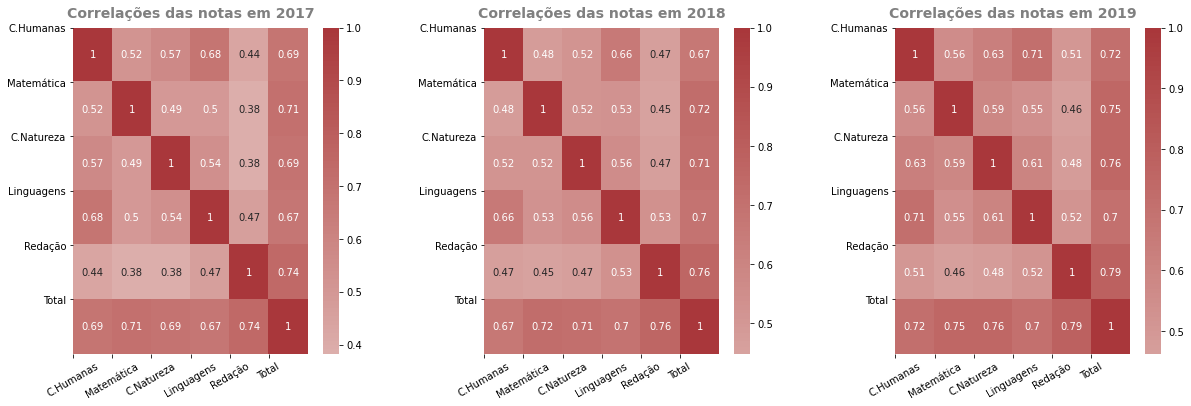

In [209]:
plt.figure(figsize=(20,6))
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  heat_corr(ano)
  i+=1

As notas que tiveram uma melhor correlação com nota total em todos os anos foram as de Redação, observe que é uma correlação positiva, significa que quanto melhor uma pessoa se sair na prova de Redação, mais chances ela tem de ter um resultado melhor no final.

Já entre as próprias provas temos que a melhor correlação em todos os anos é entre as provas de Linguagens e Códigos e a de Ciências Humanas, uma possível explicação para isso é que desde 2017 elas são realizadas sempre no primeiro dia de Enem (um domingo), para confirmarmos essa HIPÓTESE precisaríamos analisar os dados dos anos anteriores a 2017, pois as ordens das provas eram diferentes e elas eram feitas durante o mesmo final de semana (daria uma boa análise).

## (Incompleto) Distribuição de participantes por Município

In [48]:
municipio_2017 = pd.DataFrame(enem_ba_2017['NO_MUNICIPIO_RESIDENCIA'].value_counts()).reset_index()
municipio_2017.columns = ['MUNICIPIO', 'COUNT']
municipio_2017['ANO'] = 2017

municipio_2018 = pd.DataFrame(enem_ba_2018['NO_MUNICIPIO_RESIDENCIA'].value_counts()).reset_index()
municipio_2018.columns = ['MUNICIPIO', 'COUNT']
municipio_2018['ANO'] = 2018

municipio_2019 = pd.DataFrame(enem_ba_2019['NO_MUNICIPIO_RESIDENCIA'].value_counts()).reset_index()
municipio_2019.columns = ['MUNICIPIO', 'COUNT']
municipio_2019['ANO'] = 2019

municipio_df = pd.concat([municipio_2017, municipio_2018, municipio_2019])
municipio_df.tail()

,MUNICIPIO,COUNT,ANO
412,Caatiba,48,2019
413,Jucuruçu,40,2019
414,Catolândia,39,2019
415,Ibiquera,31,2019
416,Lajedinho,31,2019


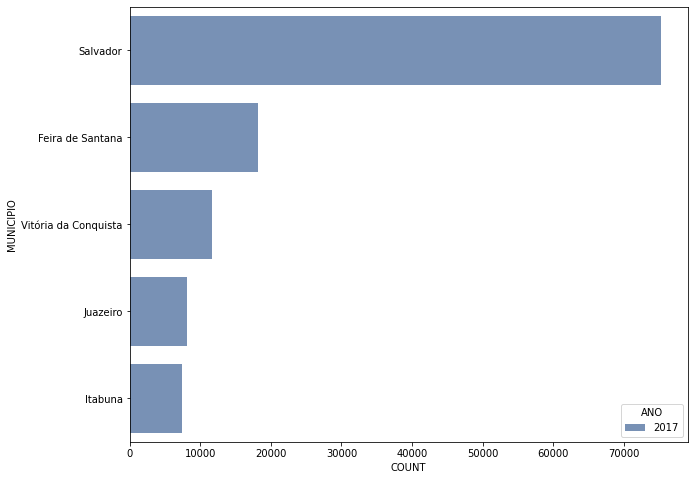

In [49]:
plt.figure(figsize=(10,8))
sns.barplot(data=municipio_df.iloc[:5,:], x='COUNT', y='MUNICIPIO', hue='ANO')

In [50]:
municipio_2017.iloc[:5,:]

,MUNICIPIO,COUNT,ANO
0,Salvador,75245,2017
1,Feira de Santana,18131,2017
2,Vitória da Conquista,11624,2017
3,Juazeiro,8084,2017
4,Itabuna,7481,2017


## Impacto da Renda familiar (Q006) nas notas totais

In [243]:
def box_impacto(df, x):
  sns.boxplot(data=df, x=x, y='NU_NOTA_TOTAL', hue='NU_ANO', order=sorted(df[x].unique()), hue_order=[2017,2018,2019])
  sns.despine(bottom = True, left = True)
  plt.grid(False)
  plt.legend(loc='lower right')
  plt.ylabel('Nota total', labelpad=15, fontsize=12)

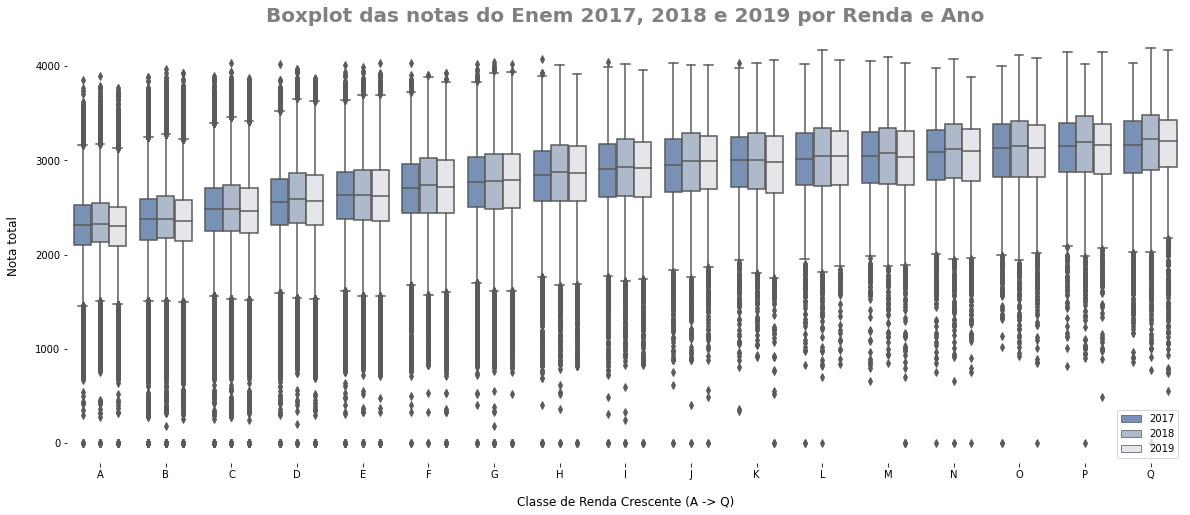

In [244]:
plt.figure(figsize=(20,8))
plt.title('Boxplot das notas do Enem 2017, 2018 e 2019 por Renda e Ano', fontsize=20, color='grey', fontweight='heavy')
box_impacto(pd.concat(lista_de_dataframes), 'Q006')
plt.xlabel('Classe de Renda Crescente (A -> Q)', labelpad = 15, fontsize=12)
plt.show()

Podemos observar que em todos os anos, sem exceção, as notas infelizmente são muito impactadas pela renda familiar de cada participante da prova do Enem, isso deve-se a diversos fatores sociais presentes no nosso país e escancara ainda mais a distância entre ricos e pobres no Brasil.

## Formação do pai e da mãe, respectivamente Q001 E Q002

### Impacto da formação do pai na nota total do Enem na Bahia

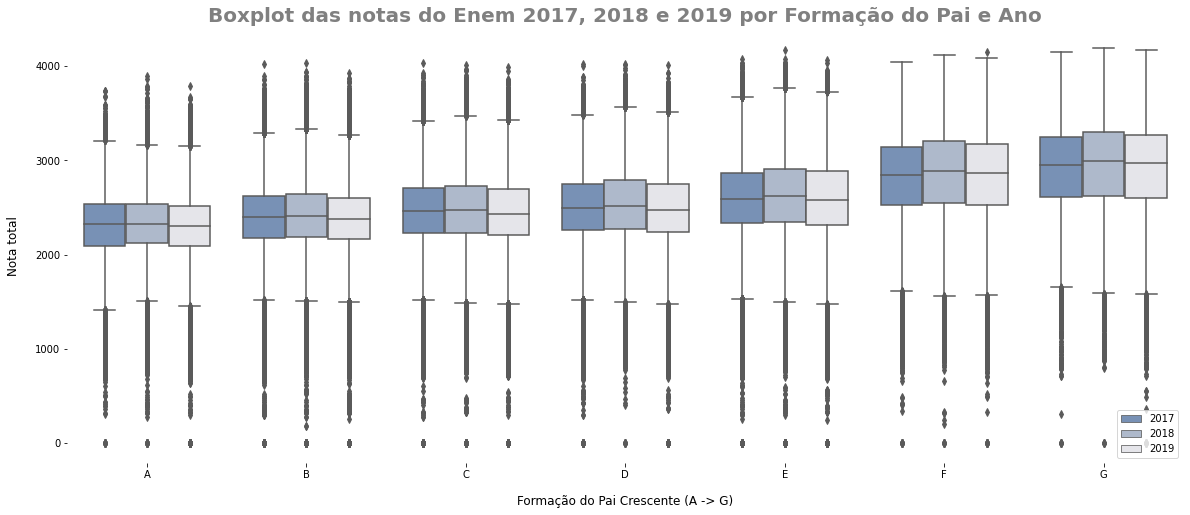

In [245]:
# Iremos tirar os valores H da coluna 'Q001' pois significam a resposta 'Não sei'
plt.figure(figsize=(20,8))
plt.title('Boxplot das notas do Enem 2017, 2018 e 2019 por Formação do Pai e Ano', fontsize=20, color='grey', fontweight='heavy')
box_impacto(pd.concat(lista_de_dataframes)[pd.concat(lista_de_dataframes)['Q001'] != 'H'], 'Q001')
plt.xlabel('Formação do Pai Crescente (A -> G)', labelpad=15, fontsize=12)
plt.show()

### Impacto da formação da mãe na nota total do Enem na Bahia

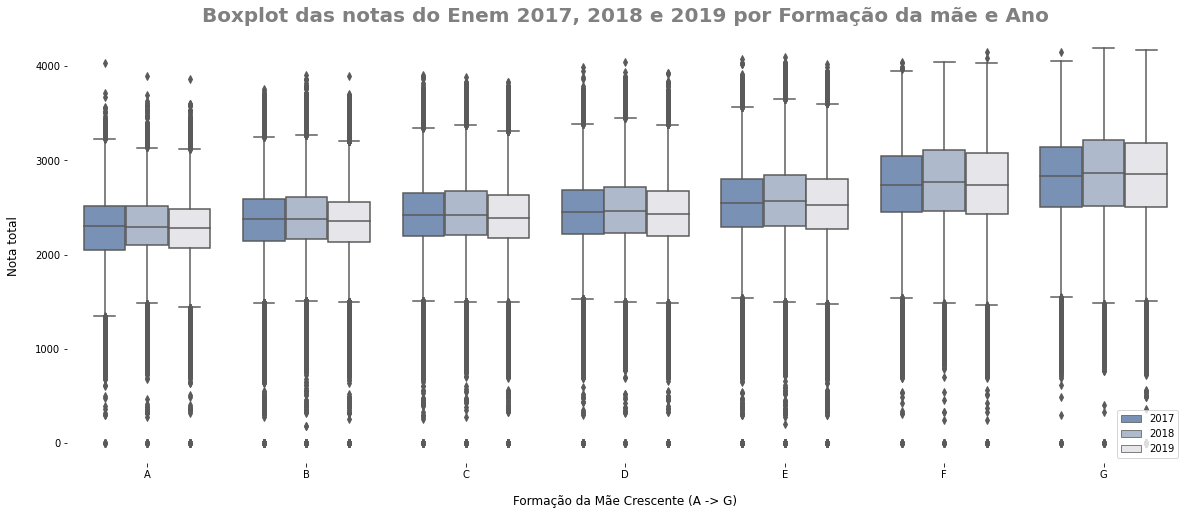

In [246]:
# Iremos tirar os valores H da coluna 'Q001' pois significam a resposta 'Não sei'
plt.figure(figsize=(20,8))
plt.title('Boxplot das notas do Enem 2017, 2018 e 2019 por Formação da mãe e Ano', fontsize=20, color='grey', fontweight='heavy')
box_impacto(pd.concat(lista_de_dataframes)[pd.concat(lista_de_dataframes)['Q002'] != 'H'], 'Q002')
plt.xlabel('Formação da Mãe Crescente (A -> G)', labelpad=15, fontsize=12)
plt.show()

Da mesma forma que vimos a renda familiar influenciando bastante na nota total dos alunos, podemos observar também analisando a formação de seus pais, mais uma prova do reflexo da desigualdade social no Brasil.

## Qual o impacto do fator de um participante não ter internet, celular e/ou computador em casa na nota total?

In [247]:
# Transformando as colunas que informam sobre o participante ter um ou mais celular em casa e ter um ou mais computadores em casa
# em apenas uma coluna que indica se eles têm ao menos 1 celular ou 1 computador em casa

for df in lista_de_dataframes:
  df['PC_CELULAR'] = ((df['Q022'] != 'A') | (df['Q024'] != 'A')).values
  df['PC_CELULAR'] = df['PC_CELULAR'].apply(lambda x: 'B' if x else 'A')

In [248]:
for df in lista_de_dataframes:
  df['TEM_COMO_ESTUDAR'] = ((df['Q025'] == 'A') | (df['PC_CELULAR'] == 'A')).values # NÃO TEM NET OU CEL_PC
  df['TEM_COMO_ESTUDAR'] = df['TEM_COMO_ESTUDAR'].apply(lambda x: 'A' if x else 'B') # RETORNA B CASO TENHA OU 1 OU NENHUM DOS DOIS, RETORNA A QUANDO TEM OS DOIS

In [254]:
def box_tem_como_estudar(df):
  plt.subplots_adjust(wspace=0.3)
  sns.despine(bottom = True, left = True)
  sns.boxplot(data=df, x='TEM_COMO_ESTUDAR', y='NU_NOTA_TOTAL')
  plt.title('Teve como estudar em casa (Enem {})?'.format(int(df['NU_ANO'].mean())), fontsize=12, color='grey', fontweight='heavy')
  plt.xticks(ticks=[0,1], labels=['Teve', 'Não teve'])
  plt.xlabel('Teve Acesso a Estudo Virtual em Casa', labelpad = 15, fontsize=10)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)

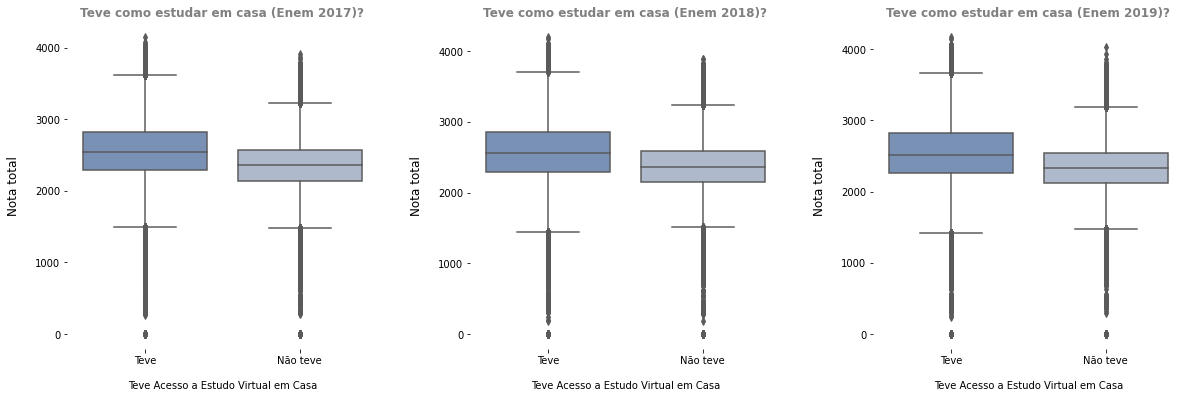

In [255]:
plt.figure(figsize=(20,6))
i=1
for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  box_tem_como_estudar(ano)
  i+=1

O fato de um participante:


*   Não ter internet nem celular ou computador em casa
*   Ter internet mas não ter celular ou computador em casa
*   Ter celular ou computador em casa mas não ter internet

Fazem com que o participante não tenha como estudar, portanto, é bem plausível que a sua nota total seja inferior aos alunos que possuem esses benefícios, como mostrado nos gráficos acima.



## Relação entre a cor/raça do participante com as suas notas

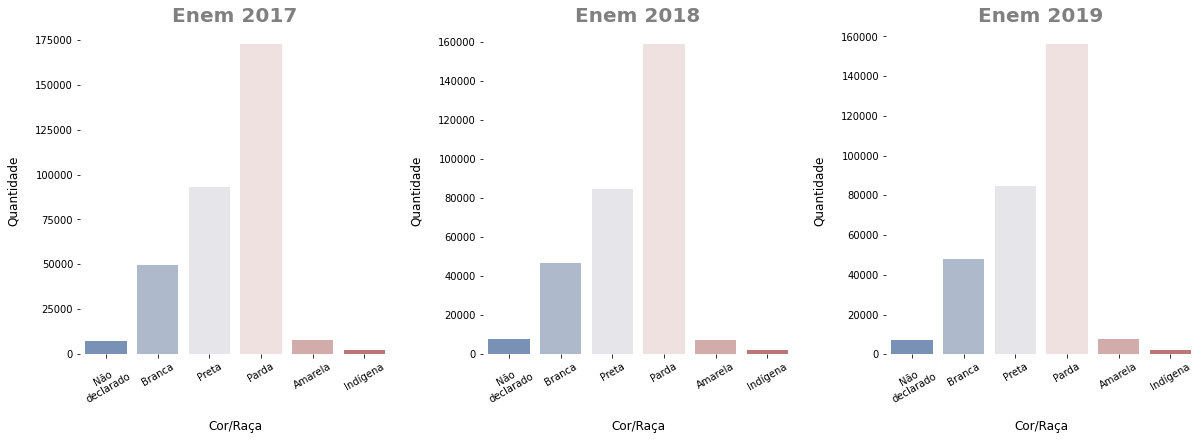

In [258]:
plt.figure(figsize=(20,6))
i=1

for df in lista_de_dataframes:
  plt.subplots_adjust(wspace=0.3)
  plt.subplot(1,3,i)
  sns.countplot(data=df, x='TP_COR_RACA')
  plt.title('Enem {}'.format(int(df['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xticks([0,1,2,3,4,5], ['Não\ndeclarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'], rotation=30)
  plt.xlabel('Cor/Raça', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

Pardos e pretos são aproximadamente 80% de todos os participantes do Enem na Bahia nos 3 anos.

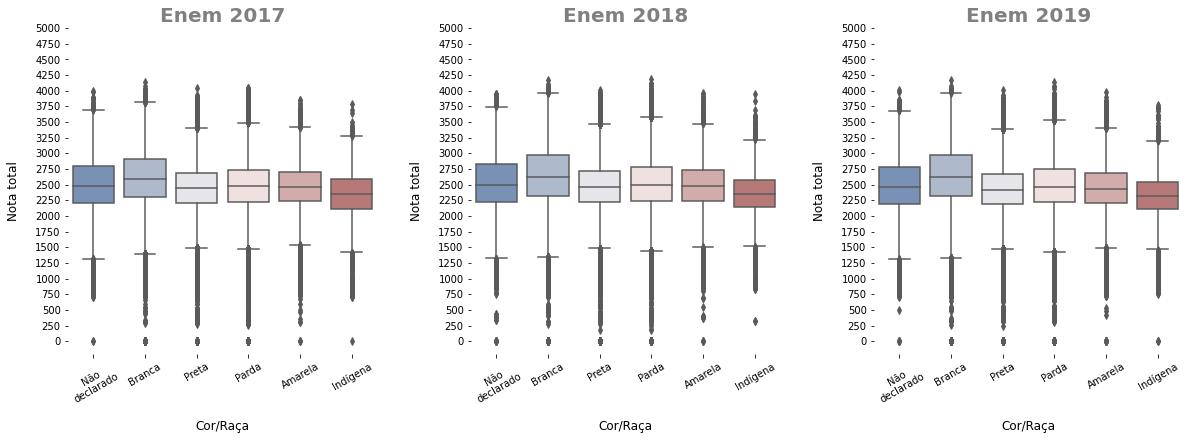

In [274]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for df in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=df, x='TP_COR_RACA', y='NU_NOTA_TOTAL')
  plt.title('Enem {}'.format(int(df['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xticks([0,1,2,3,4,5], ['Não\ndeclarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'], rotation=30)
  plt.yticks(np.arange(0,5250,250))
  plt.xlabel('Cor/Raça', labelpad = 15, fontsize=12)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

Apesar de pretos e pardos representarem aproximadamente 80% dos participantes do Enem na Bahia, as pessoas de cor autodeclarada branca tendem a ter notas mais altas do que as demais, isso ainda é reflexo da era da escravidão no país (pardos também sofrem com isso devido à missigenação), visto que as pessoas que são descendentes dos humanos escravizados na época, maior parte formadora das favelas e morros brasileiros, ainda têm dificuldade de inserirem-se na sociedade de forma igualitária, tem também a dificuldade de acesso ao ensino para os indígenas, o que faz com que esse grupo tenha muita dificuldade nessa prova (tem os menores 3º quartis em todos os anos, aproximadamente 75% das notas ficam abaixo).

<b>Isso tudo só reforça que SIM, as cotas para ingresso em Universidades no Brasil ainda são MUITO necessárias.<b>

## O sexo influencia nas notas do Enem Baiano?

In [261]:
df_sexo_2017 = pd.DataFrame(enem_ba_2017[['TP_SEXO']].value_counts()).reset_index()
df_sexo_2017.columns = ['SEXO', 'COUNT']

df_sexo_2018 = pd.DataFrame(enem_ba_2018[['TP_SEXO']].value_counts()).reset_index()
df_sexo_2018.columns = ['SEXO', 'COUNT']

df_sexo_2019 = pd.DataFrame(enem_ba_2019[['TP_SEXO']].value_counts()).reset_index()
df_sexo_2019.columns = ['SEXO', 'COUNT']

In [262]:
df_sexo_2017.head()

,SEXO,COUNT
0,F,205994
1,M,127167


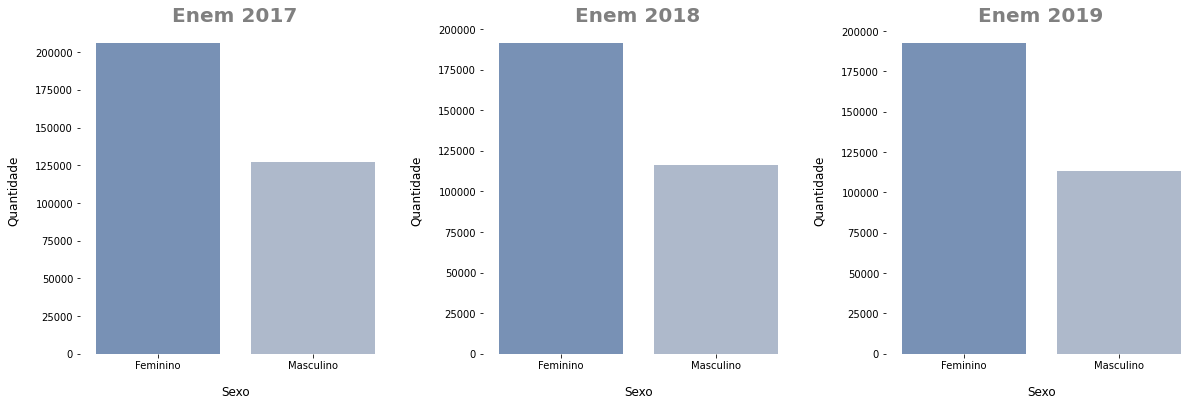

In [269]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for df in [df_sexo_2017, df_sexo_2018, df_sexo_2019]:
  plt.subplot(1,3,i)
  sns.barplot(data=df, x='SEXO', y='COUNT', order=['F','M'])
  plt.title('Enem {}'.format(2016+i), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Sexo', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  plt.xticks([0,1], ['Feminino', 'Masculino'])
  sns.despine(bottom = True, left = True)
  i+=1

Como podemos ver aqui, maioria do público do Enem é feminino em todos os anos.

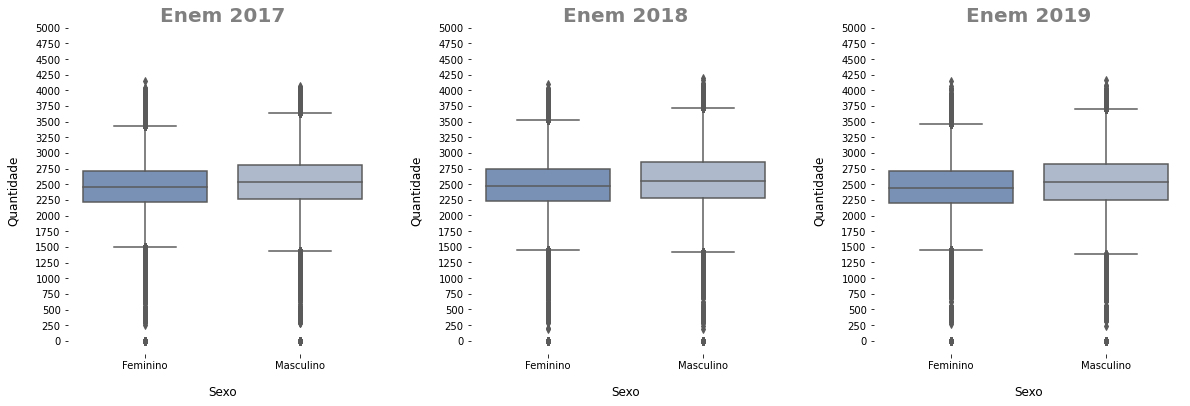

In [275]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for df in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=df, x='TP_SEXO', y='NU_NOTA_TOTAL', order=['F','M'])
  plt.title('Enem {}'.format(int(df['NU_ANO'].mean())), fontsize=20, color='grey', fontweight='heavy')
  plt.xlabel('Sexo', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  plt.yticks(np.arange(0,5250,250))
  plt.xticks([0,1], ['Feminino', 'Masculino'])
  sns.despine(bottom = True, left = True)
  i+=1

O sexo do participante não parece ter nenhuma relação com a nota total.

## Atendimento especializado e específico

In [276]:
pedidos = ['IN_ATENDIMENTO_ESPECIALIZADO', 'IN_ATENDIMENTO_ESPECIFICO']
print('RELATÓRIO DE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO')

for pedido in pedidos:
  print('\n---------------------------------\n{} == 1\n'.format(pedido),'---------------------------------')
  for ano in lista_de_dataframes:
    print('({0}) Qntd bruta: {1}'
    .format(int(ano['NU_ANO'].mean()), (ano[pedido].value_counts()[1])))
    print('({0}) Porcentagem: {1:.2f}%'
    .format(int(ano['NU_ANO'].mean()), (ano[pedido].value_counts()[1]/len(ano))*100),'\n')

RELATÓRIO DE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO

---------------------------------
IN_ATENDIMENTO_ESPECIALIZADO == 1
 ---------------------------------
(2017) Qntd bruta: 1664
(2017) Porcentagem: 0.50% 

(2018) Qntd bruta: 1417
(2018) Porcentagem: 0.46% 

(2019) Qntd bruta: 1612
(2019) Porcentagem: 0.53% 


---------------------------------
IN_ATENDIMENTO_ESPECIFICO == 1
 ---------------------------------
(2017) Qntd bruta: 325
(2017) Porcentagem: 0.10% 

(2018) Qntd bruta: 220
(2018) Porcentagem: 0.07% 

(2019) Qntd bruta: 197
(2019) Porcentagem: 0.06% 



In [277]:
print('RELATÓRIO DE CORRELAÇÃO ENTRE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO E A NOTA FINAL')

for ano in lista_de_dataframes:
  print('\n')
  for pedido in pedidos:
    print('({0}) Correlação entre {1} e a nota total: {2:.4f}'.format(int(ano['NU_ANO'].mean()), pedido, ano[[pedido, 'NU_NOTA_TOTAL']].corr().iloc[:,1][0]))

RELATÓRIO DE CORRELAÇÃO ENTRE PEDIDOS DE ATENDIMENTO ESPECIALIZADO E ESPECÍFICO E A NOTA FINAL


(2017) Correlação entre IN_ATENDIMENTO_ESPECIALIZADO e a nota total: -0.0147
(2017) Correlação entre IN_ATENDIMENTO_ESPECIFICO e a nota total: -0.0069


(2018) Correlação entre IN_ATENDIMENTO_ESPECIALIZADO e a nota total: -0.0072
(2018) Correlação entre IN_ATENDIMENTO_ESPECIFICO e a nota total: -0.0091


(2019) Correlação entre IN_ATENDIMENTO_ESPECIALIZADO e a nota total: -0.0103
(2019) Correlação entre IN_ATENDIMENTO_ESPECIFICO e a nota total: -0.0031


Podemos observar que a quantidade de pessoas que possuem essas características é muito pequena, além de em todos os anos possuírem uma correlação muito baixa com a nota total, dessa forma principalmente pela pouquíssima quantidade de dados representando esses tipos de atendimentos não podemos tirar nenhuma conclusão sobre essas características.

## Tipo de escola do ensino médio

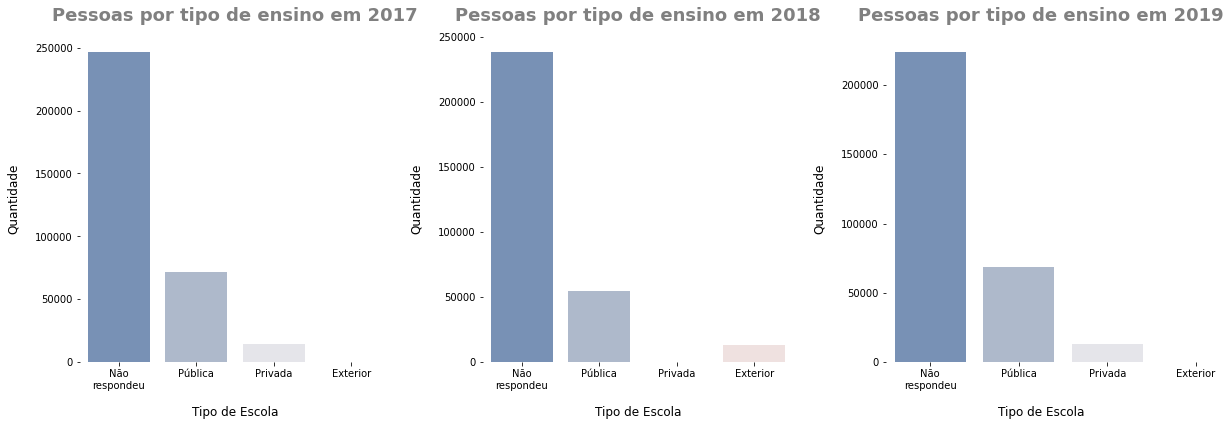

In [282]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.countplot(data=ano, x='TP_ESCOLA')
  plt.title('Pessoas por tipo de ensino em {}'.format(int(ano['NU_ANO'].mean())), fontsize=18, color='grey', fontweight='heavy', pad=15)
  plt.xticks([0,1,2,3], ['Não\nrespondeu', 'Pública', 'Privada', 'Exterior'])
  plt.xlabel('Tipo de Escola', labelpad = 15, fontsize=12)
  plt.ylabel('Quantidade', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

A maior parte dos participantes não responderam, mas dos que responderam, durante os 3 anos a escola pública tem muito mais participantes do que nas privadas e exteriores.

In [283]:
enem_ba_2017['TP_ESCOLA'].value_counts()

1.0    246849
2.0     71825
3.0     14276
4.0       211
Name: TP_ESCOLA, dtype: int64

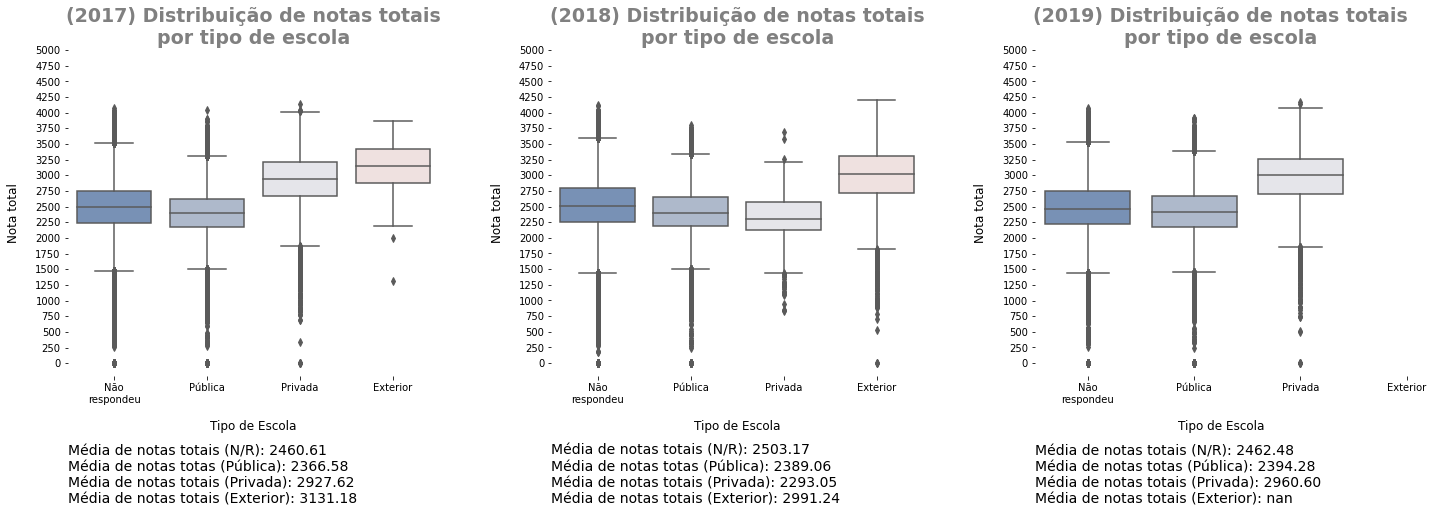

In [286]:
plt.figure(figsize=(24,6))
plt.subplots_adjust(wspace=0.3)
i=1

for ano in lista_de_dataframes:
  plt.subplot(1,3,i)
  sns.boxplot(data=ano, x='TP_ESCOLA', y='NU_NOTA_TOTAL')
  plt.title('({}) Distribuição de notas totais\npor tipo de escola'.format(int(ano['NU_ANO'].mean())), fontsize=19, color='grey', fontweight='heavy')
  plt.xticks([0,1,2,3], ['Não\nrespondeu', 'Pública', 'Privada', 'Exterior'])
  plt.yticks(np.arange(0,5250,250))
  plt.text(x=-0.5, y=-2500, fontsize=14, s='Média de notas totais (N/R): {:.2f}\nMédia de notas totas (Pública): {:.2f}\nMédia de notas totais (Privada): {:.2f}\nMédia de notas totais (Exterior): {:.2f}\n'
  .format(ano[ano['TP_ESCOLA'] == 1]['NU_NOTA_TOTAL'].mean(), ano[ano['TP_ESCOLA'] == 2]['NU_NOTA_TOTAL'].mean(),
          ano[ano['TP_ESCOLA'] == 3]['NU_NOTA_TOTAL'].mean(), ano[ano['TP_ESCOLA'] == 4]['NU_NOTA_TOTAL'].mean()))
  plt.xlabel('Tipo de Escola', labelpad = 15, fontsize=12)
  plt.ylabel('Nota total', labelpad = 15, fontsize=12)
  sns.despine(bottom = True, left = True)
  i+=1

Uma curiosidade é que o ano de 2018 é o único no qual temos a média e a distribuição de notas totais do ensino público sendo superior à do ensino privado, mas acontece que isso torna pouco conclusivo pois como foi dito anteriormente, a quantidade de alunos que não responderam é muito alta, portanto essa característica é pouco relevante para o estudo.

# Conclusões

# Modelo para predição da nota total

# Referências